**Summary of Project**

In this project, I fetch the sequence 3 different measures of B-Factor for the 2BXO protein. Then, I train 4 different models to predict each of its different types of B-Factor:

1. Varients of linear regression models
2. A simple RNN model
3. An LSTM model
4. An LSTM with multi-head self-attention (transformer)

We iterate through 9 variations of hyperparameters for each model architecture, and then graph how well they predict the various measures of B-Factor for all 4, and print the best Pearson Correlation Co-effiecent.

Then, we get the ProBERT embeddings for each residue in the protein sequence, and then again train the 4 different models to predict B-Factor using the embeddings:

1. Varients of linear regression models
2. A simple RNN model
3. An LSTM model
4. An LSTM with multi-head self-attention (transformer)

Again, for each of these models, our code iterates through 9 variations of their hyperparameters and selects the best one. Then, we display graohs to display how well all 4 predict the various measures of B-Factor, and print the highest Pearson Correlation Co-effecient obtained.

In [2]:
pip install bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 24.3 MB/s eta 0:00:00


**Cells 1-3: Data Loading & Preparation**

In [3]:
import pandas as pd
from Bio.PDB import PDBList, PDBParser
from Bio.PDB.Polypeptide import is_aa
pdbl = PDBList()

# Amino acid 3-letter to 1-letter code dictionary
aa_3to1 = {
    "ALA": "A", "ARG": "R", "ASN": "N", "ASP": "D", "CYS": "C",
    "GLU": "E", "GLN": "Q", "GLY": "G", "HIS": "H", "ILE": "I",
    "LEU": "L", "LYS": "K", "MET": "M", "PHE": "F", "PRO": "P",
    "SER": "S", "THR": "T", "TRP": "W", "TYR": "Y", "VAL": "V"
}

# List of known PDB IDs with well-characterized structures
pdb_ids = ['2BXO']

def get_pdb_sequence_and_b_factors(pdb_id):
    try:
        # Download the PDB file
        pdb_file = pdbl.retrieve_pdb_file(pdb_id, file_format="pdb")
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure(pdb_id, pdb_file)

        sequences = []
        b_factors = []

        for model in structure:
            for chain in model:
                chain_sequence = ""
                avg_b_factors = []
                backbone_b_factors = []
                sidechain_b_factors = []
                ca_b_factors = []
                last_residue_id = None  # To track for discontinuities

                for residue in chain.get_residues():
                    if is_aa(residue, standard=True):  # Only consider standard amino acids
                        if last_residue_id is not None:
                            # Check for discontinuities (gaps)
                            gap = residue.get_id()[1] - last_residue_id
                            if gap > 1:
                                print(f"Gap detected in chain {chain.get_id()} of {pdb_id}. Skipping chain.")
                                return [], []  # Skip the chain if a gap is detected

                        # Get residue name and sequence
                        resname = residue.resname.strip()
                        chain_sequence += aa_3to1[resname]  # Convert to 1-letter code

                        # Calculate B-factor metrics
                        all_b_factors = [atom.get_bfactor() for atom in residue]
                        avg_b_factors.append(sum(all_b_factors) / len(all_b_factors))

                        # Separate backbone and sidechain atoms
                        backbone_atoms = ["N", "CA", "C", "O"]
                        backbone_b = [atom.get_bfactor() for atom in residue if atom.get_name() in backbone_atoms]
                        sidechain_b = [atom.get_bfactor() for atom in residue if atom.get_name() not in backbone_atoms]
                        ca_b = [atom.get_bfactor() for atom in residue if atom.get_name() == "CA"]

                        # Calculate metrics and handle cases where certain atom types are missing
                        if backbone_b:
                            backbone_b_factors.append(sum(backbone_b) / len(backbone_b))
                        else:
                            backbone_b_factors.append(None)  # Append None if no backbone atoms are present

                        if sidechain_b:
                            sidechain_b_factors.append(sum(sidechain_b) / len(sidechain_b))
                        else:
                            sidechain_b_factors.append(None)  # Append None if no sidechain atoms are present

                        if ca_b:
                            ca_b_factors.append(ca_b[0])  # Only one CA atom per residue, so just take it directly
                        else:
                            ca_b_factors.append(None)  # Append None if CA atom is missing

                        last_residue_id = residue.get_id()[1]  # Track the residue ID

                if len(chain_sequence) == len(avg_b_factors):  # Ensure sequence matches B-factors
                    sequences.append(chain_sequence)
                    b_factors.append({
                        "avg_b_factor": avg_b_factors,
                        "backbone_b_factor": backbone_b_factors,
                        "sidechain_b_factor": sidechain_b_factors,
                        "ca_b_factor": ca_b_factors
                    })

        return sequences, b_factors
    except Exception as e:
        print(f"Error fetching PDB {pdb_id}: {e}")
        return [], []

# Example usage
data = []
for pdb_id in pdb_ids:
    print(f"Fetching data for PDB ID: {pdb_id}")
    sequences, b_factors = get_pdb_sequence_and_b_factors(pdb_id)

    if sequences and b_factors:  # Only append if data was successfully fetched
        for seq, b_factor_dict in zip(sequences, b_factors):
            data.append({
                "pdb_id": pdb_id,
                "sequence": seq,
                "avg_b_factor": b_factor_dict["avg_b_factor"],
                "backbone_b_factor": b_factor_dict["backbone_b_factor"],
                "sidechain_b_factor": b_factor_dict["sidechain_b_factor"],
                "ca_b_factor": b_factor_dict["ca_b_factor"]
            })

# Convert the list to a pandas DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

Fetching data for PDB ID: 2BXO
  pdb_id                                           sequence  \
0   2BXO  HKSEVAHRFKDLGEENFKALVLIAFAQYLQQCPFEDHVKLVNEVTE...   

                                        avg_b_factor  \
0  [86.82300000000001, 71.628, 62.93166666666667,...   

                                   backbone_b_factor  \
0  [81.0075, 71.465, 64.2, 61.9475, 54.5425000000...   

                                  sidechain_b_factor  \
0  [90.7, 72.28, 60.394999999999996, 76.131999999...   

                                         ca_b_factor  
0  [81.92, 71.48, 63.8, 63.57, 55.1, 53.53, 56.44...  


In [4]:
# Cell 2: Checking the data for the four B-factor types
for index, row in df.iterrows():
    sequence = row['sequence']  # The sequence for each PDB ID
    avg_b_factors = row['avg_b_factor']          # Average B-factors across all atoms
    backbone_b_factors = row['backbone_b_factor'] # Backbone B-factors (N, CA, C, O atoms only)
    sidechain_b_factors = row['sidechain_b_factor'] # Sidechain B-factors (non-backbone atoms)
    ca_b_factors = row['ca_b_factor']            # CA (alpha carbon) B-factors

    # Compare the lengths of the sequence and each type of B-factor
    seq_length = len(sequence)
    avg_b_length = len(avg_b_factors)
    backbone_b_length = len(backbone_b_factors)
    sidechain_b_length = len(sidechain_b_factors)
    ca_b_length = len(ca_b_factors)

    # Check if all lengths match
    if seq_length == avg_b_length == backbone_b_length == sidechain_b_length == ca_b_length:
        print(f"Sequence and all B-factors length match for PDB {row['pdb_id']}")
        print(f"Sequence length: {seq_length}")
        print(f"Average B-factors length: {avg_b_length}")
        print(f"Backbone B-factors length: {backbone_b_length}")
        print(f"Sidechain B-factors length: {sidechain_b_length}")
        print(f"CA B-factors length: {ca_b_length}")
    else:
        print(f"Mismatch for PDB {row['pdb_id']}")
        print(f"Sequence length: {seq_length}")
        print(f"Average B-factors length: {avg_b_length}")
        print(f"Backbone B-factors length: {backbone_b_length}")
        print(f"Sidechain B-factors length: {sidechain_b_length}")
        print(f"CA B-factors length: {ca_b_length}")

Sequence and all B-factors length match for PDB 2BXO
Sequence length: 582
Average B-factors length: 582
Backbone B-factors length: 582
Sidechain B-factors length: 582
CA B-factors length: 582


In [6]:
# Cell 3: Get positional embeddings
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Updated function to prepare features including positional encoding
def prepare_features_with_position(sequence):
    amino_acids = list(sequence)
    amino_acids_df = pd.DataFrame(amino_acids, columns=['amino_acid'])

    # One-hot encode amino acids
    encoder = OneHotEncoder(sparse_output=False)
    X_one_hot = encoder.fit_transform(amino_acids_df)

    # Add positional information as a feature (normalized position)
    positions = np.arange(len(sequence)) / len(sequence)  # Position as a fraction of the total sequence length

    # Combine one-hot encoding with positional encoding
    X = np.hstack((X_one_hot, positions.reshape(-1, 1)))

    return X

# Example usage
sequence = df['sequence'].iloc[0]
X = prepare_features_with_position(sequence)


Training models for avg_b_factor
Linear Regression - avg_b_factor:
Pearson Correlation: 0.4093
MSE: 88.3065

Ridge Regression - avg_b_factor:
Pearson Correlation: 0.4093
MSE: 88.1830

Lasso Regression - avg_b_factor:
Pearson Correlation: 0.3676
MSE: 84.9998

Saved best model for avg_b_factor as Ridge Regression_avg_b_factor.joblib

Training models for backbone_b_factor
Linear Regression - backbone_b_factor:
Pearson Correlation: 0.3657
MSE: 83.9299

Ridge Regression - backbone_b_factor:
Pearson Correlation: 0.3660
MSE: 83.7953

Lasso Regression - backbone_b_factor:
Pearson Correlation: 0.3533
MSE: 78.3187

Saved best model for backbone_b_factor as Ridge Regression_backbone_b_factor.joblib

Training models for ca_b_factor
Linear Regression - ca_b_factor:
Pearson Correlation: 0.3760
MSE: 83.7247

Ridge Regression - ca_b_factor:
Pearson Correlation: 0.3763
MSE: 83.5912

Lasso Regression - ca_b_factor:
Pearson Correlation: 0.3563
MSE: 78.6555

Saved best model for ca_b_factor as Ridge Regr

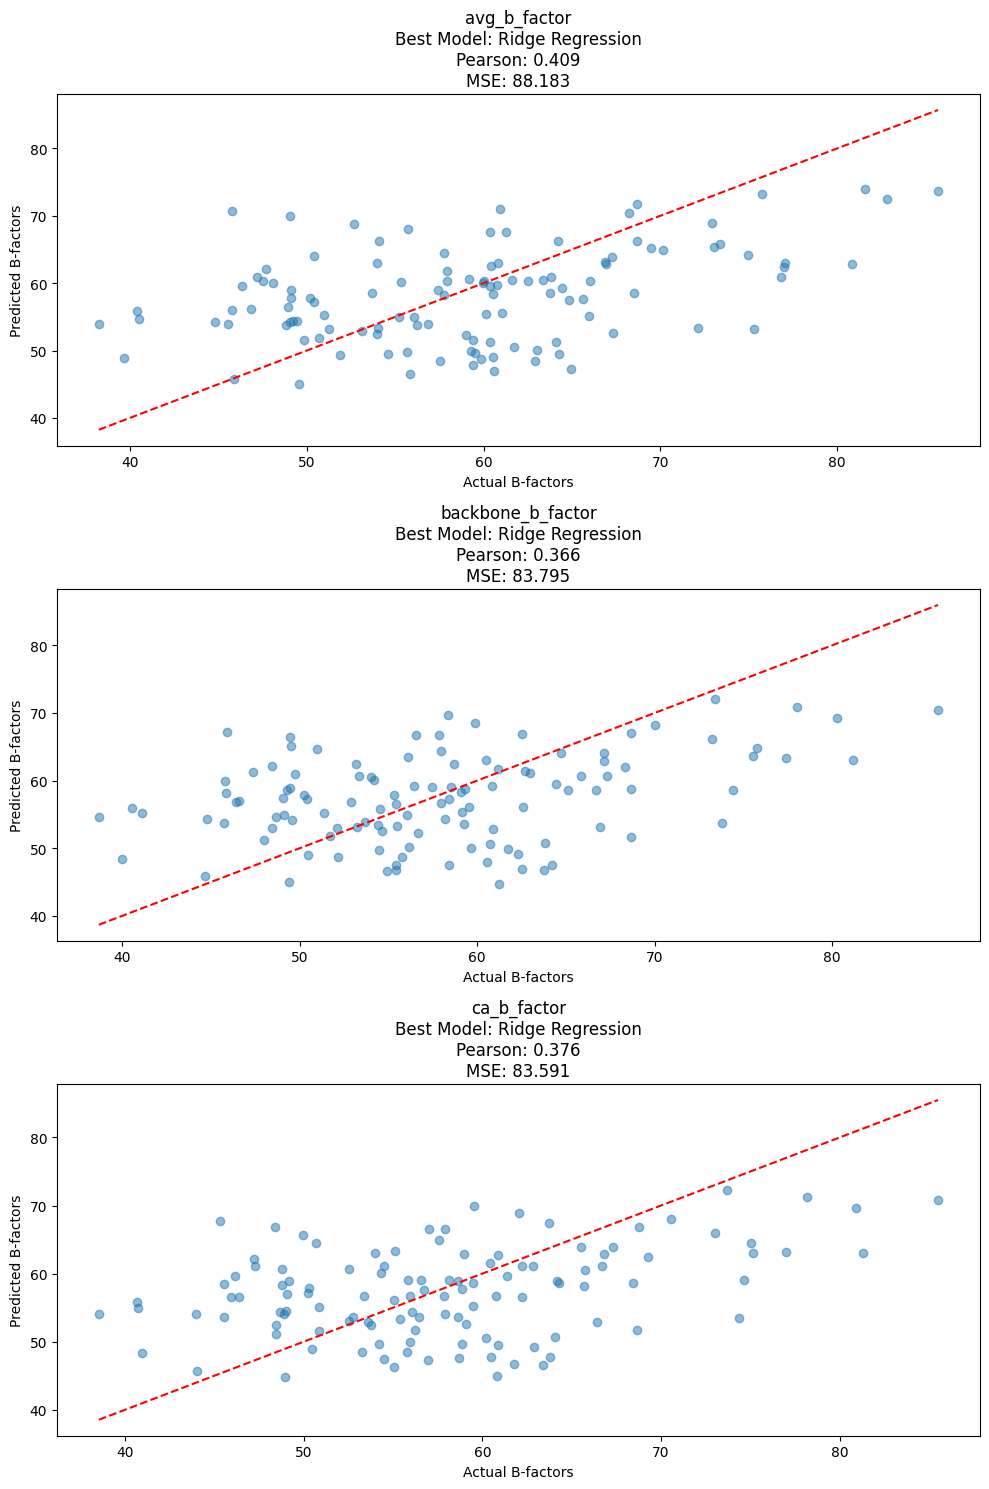


Summary of Best Models:
B-factor Type   Best Model           Pearson    MSE       
------------------------------------------------------------
avg_b_factor    Ridge Regression     0.4093    88.1830
backbone_b_factor Ridge Regression     0.3660    83.7953
ca_b_factor     Ridge Regression     0.3763    83.5912


In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import joblib  # For saving models

def prepare_features_with_position(sequence):
    # One-hot encode amino acids
    amino_acids = list(sequence)
    amino_acids_df = pd.DataFrame(amino_acids, columns=['amino_acid'])
    encoder = OneHotEncoder(sparse_output=False)
    X_one_hot = encoder.fit_transform(amino_acids_df)

    # Normalize one-hot encoded features
    X_one_hot = X_one_hot / np.sqrt(X_one_hot.shape[1])

    # Add positional information (normalized position)
    positions = np.arange(len(sequence)) / len(sequence)

    # Combine features
    X = np.hstack((X_one_hot, positions.reshape(-1, 1)))

    return X

def train_models_for_b_factor(df, b_factor_type, save_model=True):
    # Prepare data
    sequence = df['sequence'].iloc[0]
    b_factors = df[b_factor_type].iloc[0]
    X = prepare_features_with_position(sequence)
    y = np.array(b_factors)
    y_scaler = MinMaxScaler()
    y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize Models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=0.01),
        'Lasso Regression': Lasso(alpha=0.001)
    }

    best_result = None
    best_pearson = -float('inf')

    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Transform back to original scale
        y_pred_original = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
        y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

        # Calculate metrics
        pearson_corr, _ = pearsonr(y_test_original, y_pred_original)
        mse = mean_squared_error(y_test_original, y_pred_original)

        # Store result if best
        if pearson_corr > best_pearson:
            best_pearson = pearson_corr
            best_result = {
                'model_name': name,
                'model': model,
                'pearson_corr': pearson_corr,
                'mse': mse,
                'predictions': y_pred_original,
                'targets': y_test_original
            }

        print(f"{name} - {b_factor_type}:")
        print(f"Pearson Correlation: {pearson_corr:.4f}")
        print(f"MSE: {mse:.4f}\n")

    # Save the best model if specified
    if save_model and best_result is not None:
        model_filename = f"{best_result['model_name']}_{b_factor_type}.joblib"
        joblib.dump(best_result['model'], model_filename)
        print(f"Saved best model for {b_factor_type} as {model_filename}")

    return best_result

# Train models for each B-factor type
b_factor_types = ["avg_b_factor", "backbone_b_factor", "ca_b_factor"]
best_results = {}

# Set up the plot
plt.figure(figsize=(10, 15))

for i, b_type in enumerate(b_factor_types):
    print(f"\nTraining models for {b_type}")
    best_result = train_models_for_b_factor(df, b_type)
    best_results[b_type] = best_result

    # Plot only the best model
    plt.subplot(3, 1, i + 1)
    plt.scatter(best_result['targets'], best_result['predictions'], alpha=0.5)
    plt.plot([min(best_result['targets']), max(best_result['targets'])],
             [min(best_result['targets']), max(best_result['targets'])], 'r--')
    plt.title(f'{b_type}\nBest Model: {best_result["model_name"]}\n' +
              f'Pearson: {best_result["pearson_corr"]:.3f}\nMSE: {best_result["mse"]:.3f}')
    plt.xlabel('Actual B-factors')
    plt.ylabel('Predicted B-factors')

# Save the overall figure
plt.tight_layout()
plt.savefig("b_factor_model_performance.png")  # Save plot
plt.show()

# Print summary table of best models
print("\nSummary of Best Models:")
print("="*60)
print(f"{'B-factor Type':<15} {'Best Model':<20} {'Pearson':<10} {'MSE':<10}")
print("-"*60)

for b_type, result in best_results.items():
    print(f"{b_type:<15} {result['model_name']:<20} {result['pearson_corr']:.4f}    {result['mse']:.4f}")


Training models for avg_b_factor

Training model: Layers: [128, 64], Batch: 32, LR: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.2723

Training model: Layers: [128, 64], Batch: 32, LR: 0.0001
Pearson Correlation: 0.0638

Training model: Layers: [128, 64], Batch: 64, LR: 0.001
Pearson Correlation: 0.3470

Training model: Layers: [128, 64], Batch: 64, LR: 0.0001
Pearson Correlation: 0.1505

Training model: Layers: [256, 128, 64], Batch: 32, LR: 0.001
Pearson Correlation: 0.4015

Training model: Layers: [256, 128, 64], Batch: 32, LR: 0.0001
Pearson Correlation: 0.1409

Training model: Layers: [256, 128, 64], Batch: 64, LR: 0.001
Pearson Correlation: 0.3727

Training model: Layers: [256, 128, 64], Batch: 64, LR: 0.0001


Pearson Correlation: 0.2932

Model Performance Summary for avg_b_factor (sorted by correlation):
--------------------------------------------------------------------------------
1. Layers: [256, 128, 64], Batch: 32, LR: 0.001
   Correlation: 0.4015
   P-value: 7.2453e-06
--------------------------------------------------------------------------------
2. Layers: [256, 128, 64], Batch: 64, LR: 0.001
   Correlation: 0.3727
   P-value: 3.4935e-05
--------------------------------------------------------------------------------
3. Layers: [128, 64], Batch: 64, LR: 0.001
   Correlation: 0.3470
   P-value: 1.2667e-04
--------------------------------------------------------------------------------
4. Layers: [256, 128, 64], Batch: 64, LR: 0.0001
   Correlation: 0.2932
   P-value: 1.3375e-03
--------------------------------------------------------------------------------
5. Layers: [128, 64], Batch: 32, LR: 0.001
   Correlation: 0.2723
   P-value: 2.9756e-03
-------------------------------------

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3328

Training model: Layers: [128, 64], Batch: 32, LR: 0.0001
Pearson Correlation: 0.2745

Training model: Layers: [128, 64], Batch: 64, LR: 0.001
Pearson Correlation: 0.2700

Training model: Layers: [128, 64], Batch: 64, LR: 0.0001
Pearson Correlation: 0.1292

Training model: Layers: [256, 128, 64], Batch: 32, LR: 0.001
Pearson Correlation: 0.3732

Training model: Layers: [256, 128, 64], Batch: 32, LR: 0.0001
Pearson Correlation: 0.3574

Training model: Layers: [256, 128, 64], Batch: 64, LR: 0.001
Pearson Correlation: 0.3826

Training model: Layers: [256, 128, 64], Batch: 64, LR: 0.0001


Pearson Correlation: 0.2833

Model Performance Summary for backbone_b_factor (sorted by correlation):
--------------------------------------------------------------------------------
1. Layers: [256, 128, 64], Batch: 64, LR: 0.001
   Correlation: 0.3826
   P-value: 2.0711e-05
--------------------------------------------------------------------------------
2. Layers: [256, 128, 64], Batch: 32, LR: 0.001
   Correlation: 0.3732
   P-value: 3.4036e-05
--------------------------------------------------------------------------------
3. Layers: [256, 128, 64], Batch: 32, LR: 0.0001
   Correlation: 0.3574
   P-value: 7.6087e-05
--------------------------------------------------------------------------------
4. Layers: [128, 64], Batch: 32, LR: 0.001
   Correlation: 0.3328
   P-value: 2.4628e-04
--------------------------------------------------------------------------------
5. Layers: [256, 128, 64], Batch: 64, LR: 0.0001
   Correlation: 0.2833
   P-value: 1.9638e-03
--------------------------

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.2957

Training model: Layers: [128, 64], Batch: 32, LR: 0.0001
Pearson Correlation: 0.3121

Training model: Layers: [128, 64], Batch: 64, LR: 0.001
Pearson Correlation: 0.3211

Training model: Layers: [128, 64], Batch: 64, LR: 0.0001
Pearson Correlation: 0.1454

Training model: Layers: [256, 128, 64], Batch: 32, LR: 0.001
Pearson Correlation: 0.3811

Training model: Layers: [256, 128, 64], Batch: 32, LR: 0.0001
Pearson Correlation: 0.3366

Training model: Layers: [256, 128, 64], Batch: 64, LR: 0.001
Pearson Correlation: 0.3540

Training model: Layers: [256, 128, 64], Batch: 64, LR: 0.0001


Pearson Correlation: 0.1945

Model Performance Summary for ca_b_factor (sorted by correlation):
--------------------------------------------------------------------------------
1. Layers: [256, 128, 64], Batch: 32, LR: 0.001
   Correlation: 0.3811
   P-value: 2.2488e-05
--------------------------------------------------------------------------------
2. Layers: [256, 128, 64], Batch: 64, LR: 0.001
   Correlation: 0.3540
   P-value: 9.0232e-05
--------------------------------------------------------------------------------
3. Layers: [256, 128, 64], Batch: 32, LR: 0.0001
   Correlation: 0.3366
   P-value: 2.0652e-04
--------------------------------------------------------------------------------
4. Layers: [128, 64], Batch: 64, LR: 0.001
   Correlation: 0.3211
   P-value: 4.1621e-04
--------------------------------------------------------------------------------
5. Layers: [128, 64], Batch: 32, LR: 0.0001
   Correlation: 0.3121
   P-value: 6.1244e-04
-------------------------------------

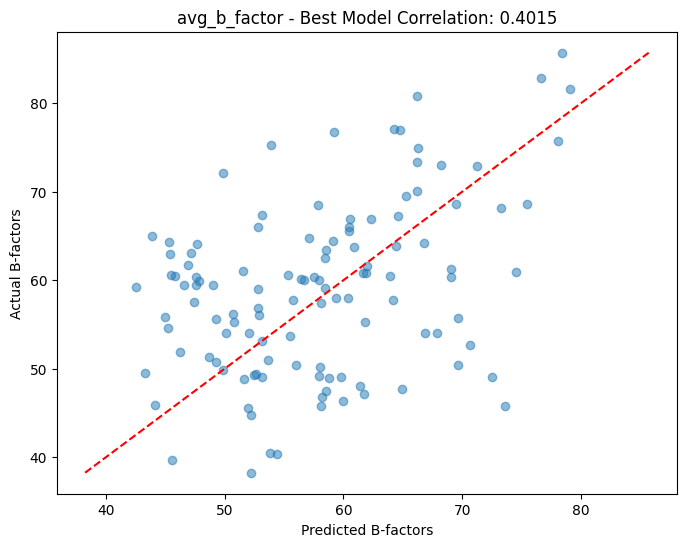

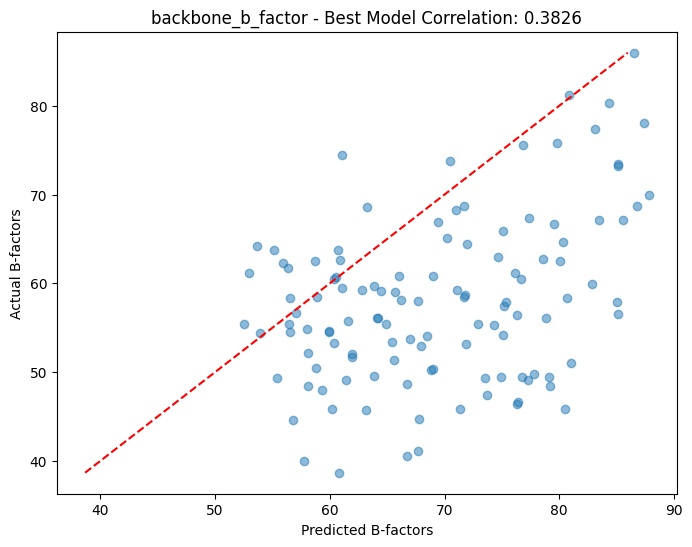

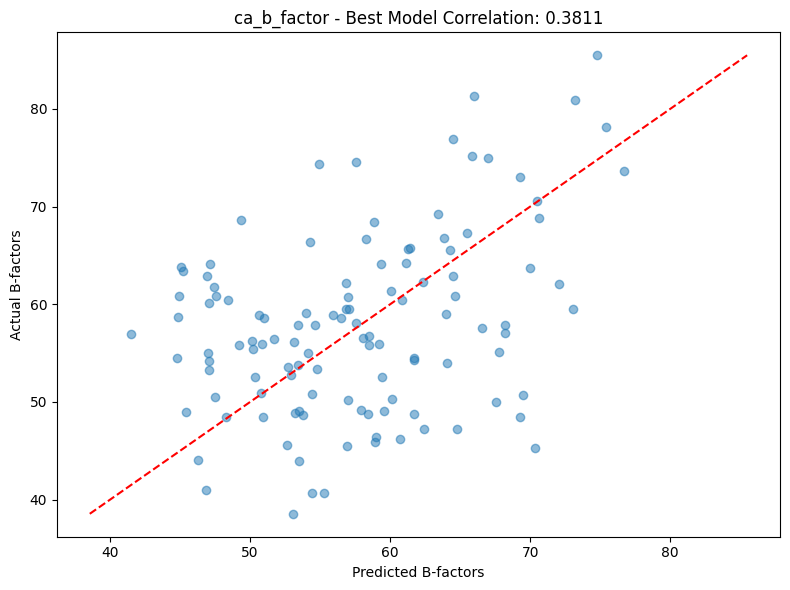


Best Model Configurations:

avg_b_factor:
Layers: [256, 128, 64]
Batch Size: 32
Learning Rate: 0.001
Correlation: 0.4015

backbone_b_factor:
Layers: [256, 128, 64]
Batch Size: 64
Learning Rate: 0.001
Correlation: 0.3826

ca_b_factor:
Layers: [256, 128, 64]
Batch Size: 32
Learning Rate: 0.001
Correlation: 0.3811


In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from itertools import product

b_factor_types = ["avg_b_factor", "backbone_b_factor", "ca_b_factor"]
all_type_results = {}

for b_factor_type in b_factor_types:
    print(f"\n{'='*40}")
    print(f"Training models for {b_factor_type}")
    print(f"{'='*40}")

    # Extract sequence and B-factors from the DataFrame
    sequence = df['sequence'].iloc[0]
    b_factors = df[b_factor_type].iloc[0]

    # Prepare input data
    amino_acids = list(sequence)
    amino_acids_df = pd.DataFrame(amino_acids, columns=['amino_acid'])

    # One-hot encode amino acids
    encoder = OneHotEncoder(sparse_output=False)
    X_amino = encoder.fit_transform(amino_acids_df)

    # Add positional encoding
    sequence_length = len(sequence)
    positions = np.arange(sequence_length) / sequence_length
    positions = positions.reshape(-1, 1)

    # Combine features
    X = np.hstack((X_amino, positions))
    y = np.array(b_factors)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define hyperparameter combinations
    layer_configurations = [
        [128, 64, 1],  # Original configuration
        [256, 128, 64, 1]  # Deeper configuration
    ]
    batch_sizes = [32, 64]
    learning_rates = [0.001, 0.0001]

    # Store results
    results = []

    # Try all combinations
    for layers, batch_size, lr in product(layer_configurations, batch_sizes, learning_rates):
        # Create model name
        model_name = f"Layers: {layers[:-1]}, Batch: {batch_size}, LR: {lr}"
        print(f"\nTraining model: {model_name}")

        # Build model
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)))

        # Add layers according to configuration
        for units in layers[:-1]:  # All layers except the last one
            model.add(tf.keras.layers.Dense(units, activation='relu'))
        model.add(tf.keras.layers.Dense(1))  # Output layer

        # Compile model
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        # Train model
        history = model.fit(
            X_train, y_train,
            epochs=10,
            batch_size=batch_size,
            validation_split=0.2,
            verbose=0
        )

        # Evaluate
        y_pred = model.predict(X_test, verbose=0)
        correlation, p_value = pearsonr(y_test, y_pred.flatten())

        # Store results
        results.append({
            'model_name': model_name,
            'model': model,
            'correlation': correlation,
            'p_value': p_value,
            'history': history.history,
            'predictions': y_pred,
            'layers': layers,
            'batch_size': batch_size,
            'learning_rate': lr
        })

        print(f"Pearson Correlation: {correlation:.4f}")

    # Sort results by correlation
    results.sort(key=lambda x: x['correlation'], reverse=True)
    all_type_results[b_factor_type] = results

    # Print summary for this B-factor type
    print(f"\nModel Performance Summary for {b_factor_type} (sorted by correlation):")
    print("-" * 80)
    for i, result in enumerate(results, 1):
        print(f"{i}. {result['model_name']}")
        print(f"   Correlation: {result['correlation']:.4f}")
        print(f"   P-value: {result['p_value']:.4e}")
        print("-" * 80)

    # Save the best model
    best_result = results[0]
    best_model = best_result['model']
    best_model_path = f"best_model_{b_factor_type}.h5"
    best_model.save(best_model_path)
    print(f"Best model for {b_factor_type} saved as {best_model_path}")

    # Plot predictions vs actuals for best model and save plot
    plt.figure(figsize=(8, 6))
    plt.scatter(best_result['predictions'], y_test, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Predicted B-factors')
    plt.ylabel('Actual B-factors')
    plt.title(f'{b_factor_type} - Best Model Correlation: {best_result["correlation"]:.4f}')
    plt.savefig(f"best_model_performance_{b_factor_type}.png")
    print(f"Visualization saved as best_model_performance_{b_factor_type}.png")

plt.tight_layout()
plt.show()

# Print best configurations for each type
print("\nBest Model Configurations:")
for b_factor_type in b_factor_types:
    best_result = all_type_results[b_factor_type][0]
    print(f"\n{b_factor_type}:")
    print(f"Layers: {best_result['layers'][:-1]}")
    print(f"Batch Size: {best_result['batch_size']}")
    print(f"Learning Rate: {best_result['learning_rate']}")
    print(f"Correlation: {best_result['correlation']:.4f}")


Training LSTM models for avg_b_factor

Training model: Layers: [128, 64], Batch: 32, LR: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3984

Training model: Layers: [128, 64], Batch: 32, LR: 0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3362

Training model: Layers: [128, 64], Batch: 64, LR: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.4009

Training model: Layers: [128, 64], Batch: 64, LR: 0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3286

Training model: Layers: [256, 128, 64], Batch: 32, LR: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3977

Training model: Layers: [256, 128, 64], Batch: 32, LR: 0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3792

Training model: Layers: [256, 128, 64], Batch: 64, LR: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3972

Training model: Layers: [256, 128, 64], Batch: 64, LR: 0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3416
Best LSTM model for avg_b_factor saved as best_lstm_model_avg_b_factor.h5
Visualization saved as best_lstm_performance_avg_b_factor.png

Training LSTM models for backbone_b_factor

Training model: Layers: [128, 64], Batch: 32, LR: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3663

Training model: Layers: [128, 64], Batch: 32, LR: 0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3013

Training model: Layers: [128, 64], Batch: 64, LR: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3651

Training model: Layers: [128, 64], Batch: 64, LR: 0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.2415

Training model: Layers: [256, 128, 64], Batch: 32, LR: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3755

Training model: Layers: [256, 128, 64], Batch: 32, LR: 0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3744

Training model: Layers: [256, 128, 64], Batch: 64, LR: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3614

Training model: Layers: [256, 128, 64], Batch: 64, LR: 0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3566
Best LSTM model for backbone_b_factor saved as best_lstm_model_backbone_b_factor.h5
Visualization saved as best_lstm_performance_backbone_b_factor.png

Training LSTM models for ca_b_factor

Training model: Layers: [128, 64], Batch: 32, LR: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3730

Training model: Layers: [128, 64], Batch: 32, LR: 0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3633

Training model: Layers: [128, 64], Batch: 64, LR: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3762

Training model: Layers: [128, 64], Batch: 64, LR: 0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.2861

Training model: Layers: [256, 128, 64], Batch: 32, LR: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3750

Training model: Layers: [256, 128, 64], Batch: 32, LR: 0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3733

Training model: Layers: [256, 128, 64], Batch: 64, LR: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3724

Training model: Layers: [256, 128, 64], Batch: 64, LR: 0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.3177
Best LSTM model for ca_b_factor saved as best_lstm_model_ca_b_factor.h5
Visualization saved as best_lstm_performance_ca_b_factor.png

Best LSTM Model Configurations:

avg_b_factor:
Layers: [128, 64]
Batch Size: 64
Learning Rate: 0.001
Correlation: 0.4009

backbone_b_factor:
Layers: [256, 128, 64]
Batch Size: 32
Learning Rate: 0.001
Correlation: 0.3755

ca_b_factor:
Layers: [128, 64]
Batch Size: 64
Learning Rate: 0.001
Correlation: 0.3762


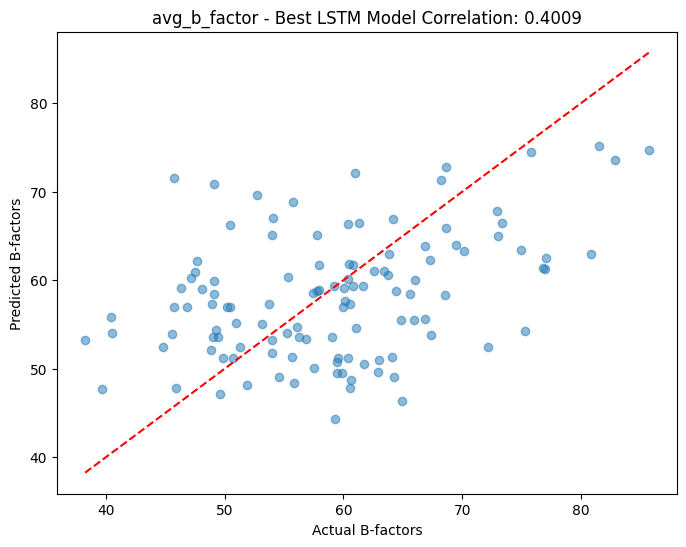

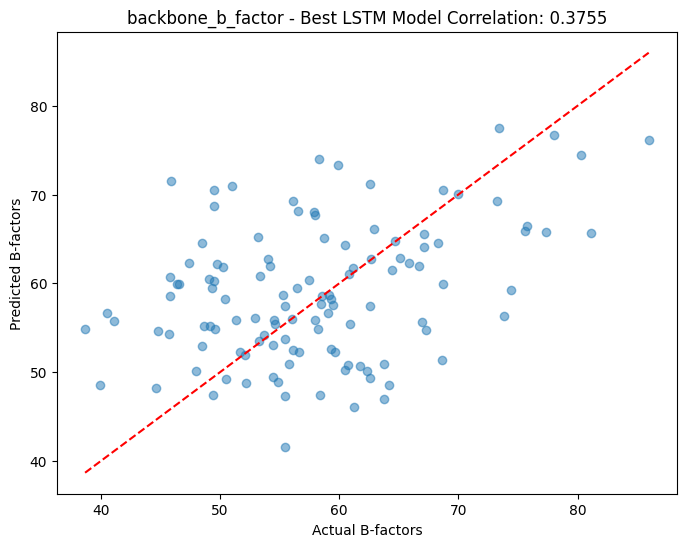

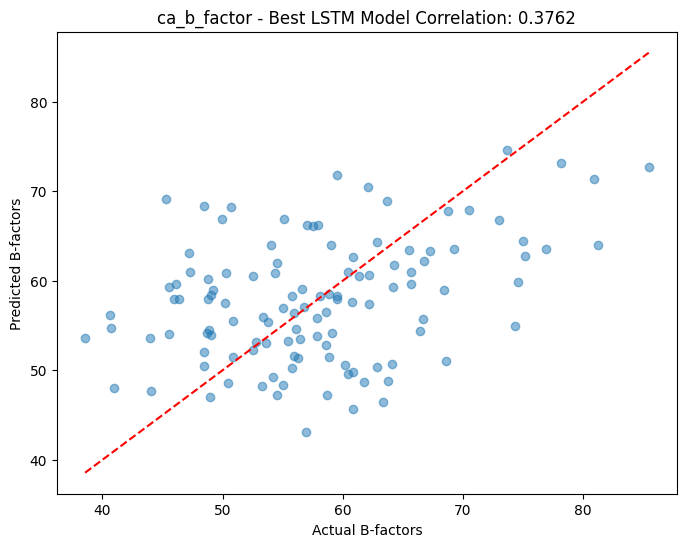

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
from itertools import product

# Define B-factor types to analyze
b_factor_types = ["avg_b_factor", "backbone_b_factor", "ca_b_factor"]

# Dictionary to store results for each B-factor type
all_type_results = {}

for b_factor_type in b_factor_types:
    print(f"\n{'='*40}")
    print(f"Training LSTM models for {b_factor_type}")
    print(f"{'='*40}")

    # Extract sequence and B-factors from the DataFrame
    sequence = df['sequence'].iloc[0]
    b_factors = df[b_factor_type].iloc[0]

    # Prepare input data
    amino_acids = list(sequence)
    amino_acids_df = pd.DataFrame(amino_acids, columns=['amino_acid'])

    # One-hot encode amino acids
    encoder = OneHotEncoder(sparse_output=False)
    X_amino = encoder.fit_transform(amino_acids_df)

    # Add positional encoding
    sequence_length = len(sequence)
    positions = np.arange(sequence_length) / sequence_length
    positions = positions.reshape(-1, 1)

    # Combine features
    X = np.hstack((X_amino, positions))

    # Reshape X for LSTM input: [samples, time steps, features]
    X = X.reshape((X.shape[0], 1, X.shape[1]))

    # Scale B-factors
    scaler = MinMaxScaler()
    y = scaler.fit_transform(np.array(b_factors).reshape(-1, 1)).flatten()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define hyperparameter combinations
    layer_configurations = [
        [128, 64, 1],  # Original configuration
        [256, 128, 64, 1]  # Deeper configuration
    ]
    batch_sizes = [32, 64]
    learning_rates = [0.001, 0.0001]

    # Store results
    results = []

    # Try all combinations
    for layers, batch_size, lr in product(layer_configurations, batch_sizes, learning_rates):
        # Create model name
        model_name = f"Layers: {layers[:-1]}, Batch: {batch_size}, LR: {lr}"
        print(f"\nTraining model: {model_name}")

        # Build LSTM model
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])))

        # Add LSTM layers
        for units in layers[:-2]:  # All layers except the last two
            model.add(tf.keras.layers.LSTM(units, return_sequences=True))

        # Add final LSTM layer
        model.add(tf.keras.layers.LSTM(layers[-2]))  # Second to last layer size

        # Add final dense layer
        model.add(tf.keras.layers.Dense(1))  # Output layer

        # Compile model
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        # Train model
        history = model.fit(
            X_train, y_train,
            epochs=20,
            batch_size=batch_size,
            validation_split=0.2,
            verbose=0
        )

        # Evaluate
        y_pred = model.predict(X_test, verbose=0)

        # Inverse transform predictions and actual values back to original scale
        y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

        correlation, p_value = pearsonr(y_test_original, y_pred_original)

        # Store results
        results.append({
            'model_name': model_name,
            'model': model,
            'correlation': correlation,
            'p_value': p_value,
            'history': history.history,
            'predictions': y_pred_original,
            'actuals': y_test_original,
            'layers': layers,
            'batch_size': batch_size,
            'learning_rate': lr
        })

        print(f"Pearson Correlation: {correlation:.4f}")

    # Sort results by correlation
    results.sort(key=lambda x: x['correlation'], reverse=True)
    all_type_results[b_factor_type] = results

    # Save the best model
    best_result = results[0]
    best_model = best_result['model']
    best_model_path = f"best_lstm_model_{b_factor_type}.h5"
    best_model.save(best_model_path)
    print(f"Best LSTM model for {b_factor_type} saved as {best_model_path}")

    # Plot predictions vs actuals for best model and save plot
    plt.figure(figsize=(8, 6))
    plt.scatter(best_result['actuals'], best_result['predictions'], alpha=0.5)
    plt.plot([min(best_result['actuals']), max(best_result['actuals'])],
             [min(best_result['actuals']), max(best_result['actuals'])], 'r--')
    plt.xlabel('Actual B-factors')
    plt.ylabel('Predicted B-factors')
    plt.title(f'{b_factor_type} - Best LSTM Model Correlation: {best_result["correlation"]:.4f}')
    plt.savefig(f"best_lstm_performance_{b_factor_type}.png")
    print(f"Visualization saved as best_lstm_performance_{b_factor_type}.png")

# Print best configurations for each type
print("\nBest LSTM Model Configurations:")
for b_factor_type in b_factor_types:
    best_result = all_type_results[b_factor_type][0]
    print(f"\n{b_factor_type}:")
    print(f"Layers: {best_result['layers'][:-1]}")
    print(f"Batch Size: {best_result['batch_size']}")
    print(f"Learning Rate: {best_result['learning_rate']}")
    print(f"Correlation: {best_result['correlation']:.4f}")


Training Transformer models for avg_b_factor

Training model: FF_dim: 128, Blocks: 2, Batch: 16, LR: 0.001
Pearson Correlation: 0.4537

Training model: FF_dim: 128, Blocks: 2, Batch: 16, LR: 0.0003
Pearson Correlation: 0.4812

Training model: FF_dim: 128, Blocks: 2, Batch: 32, LR: 0.001
Pearson Correlation: 0.4978

Training model: FF_dim: 128, Blocks: 2, Batch: 32, LR: 0.0003
Pearson Correlation: 0.5067

Training model: FF_dim: 256, Blocks: 4, Batch: 16, LR: 0.001
Pearson Correlation: 0.4618

Training model: FF_dim: 256, Blocks: 4, Batch: 16, LR: 0.0003
Pearson Correlation: 0.4773

Training model: FF_dim: 256, Blocks: 4, Batch: 32, LR: 0.001
Pearson Correlation: 0.4779

Training model: FF_dim: 256, Blocks: 4, Batch: 32, LR: 0.0003
Pearson Correlation: 0.4880
Best Transformer model for avg_b_factor saved as best_transformer_model_avg_b_factor.pt
Visualization saved as best_transformer_performance_avg_b_factor.png

Training Transformer models for backbone_b_factor

Training model: FF_di

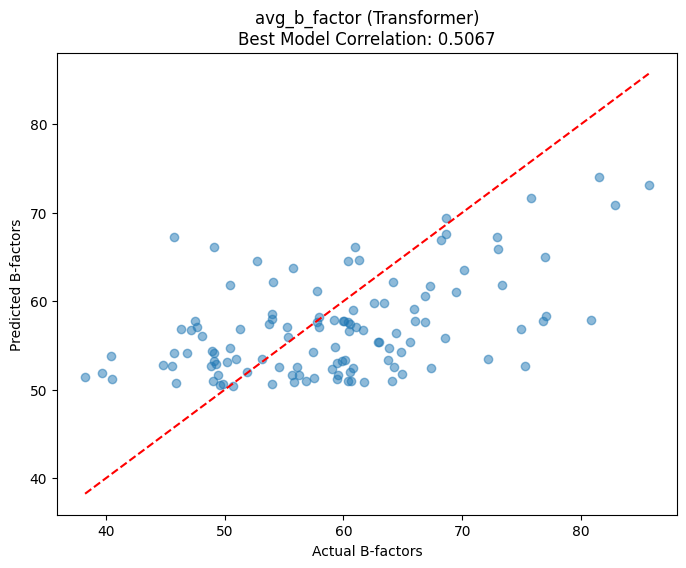

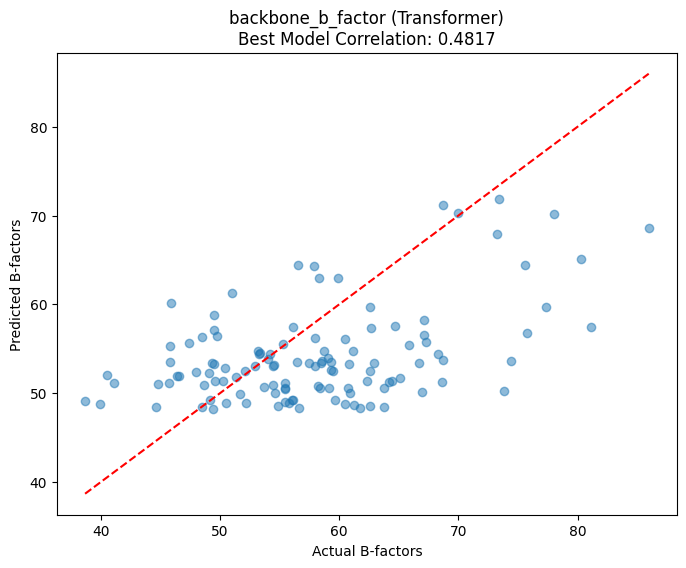

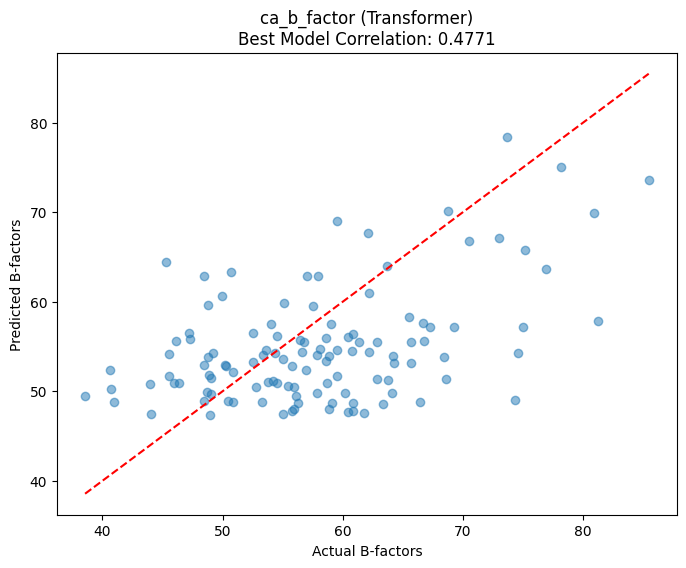

In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
from itertools import product

# Define Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, ff_dim=256, num_blocks=4, dropout=0.1):
        super().__init__()

        # Initial projection
        self.input_proj = nn.Linear(input_dim, ff_dim)

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(ff_dim, dropout) for _ in range(num_blocks)
        ])

        # Output layers
        self.layer_norm = nn.LayerNorm(ff_dim)
        self.fc1 = nn.Linear(ff_dim, 64)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, 1)
        self.gelu = nn.GELU()

    def forward(self, x):
        batch_size = x.size(0)
        x = self.input_proj(x)
        for block in self.transformer_blocks:
            x = block(x)
        x = self.layer_norm(x)
        x = self.gelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x.view(batch_size)  # Ensure output is [batch_size]

class TransformerBlock(nn.Module):
    def __init__(self, ff_dim, dropout=0.1):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(ff_dim)
        self.fc1 = nn.Linear(ff_dim, ff_dim * 4)
        self.fc2 = nn.Linear(ff_dim * 4, ff_dim)
        self.layer_norm2 = nn.LayerNorm(ff_dim)
        self.fc3 = nn.Linear(ff_dim, ff_dim)
        self.dropout = nn.Dropout(dropout)
        self.gelu = nn.GELU()

    def forward(self, x):
        residual = x
        x = self.layer_norm1(x)
        x = self.gelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = x + residual
        residual = x
        x = self.layer_norm2(x)
        x = self.gelu(self.fc3(x))
        x = self.dropout(x)
        x = x + residual
        return x

# Define B-factor types to analyze
b_factor_types = ["avg_b_factor", "backbone_b_factor", "ca_b_factor"]
all_type_results = {}

for b_factor_type in b_factor_types:
    print(f"\n{'='*40}")
    print(f"Training Transformer models for {b_factor_type}")
    print(f"{'='*40}")

    # Prepare data
    sequence = df['sequence'].iloc[0]
    b_factors = df[b_factor_type].iloc[0]

    # Encode sequence
    amino_acids = list(sequence)
    amino_acids_df = pd.DataFrame(amino_acids, columns=['amino_acid'])
    encoder = OneHotEncoder(sparse_output=False)
    X_amino = encoder.fit_transform(amino_acids_df)

    # Add positional encoding
    sequence_length = len(sequence)
    positions = np.arange(sequence_length) / sequence_length
    positions = positions.reshape(-1, 1)

    # Combine features and convert to PyTorch tensors
    X = np.hstack((X_amino, positions))
    scaler = MinMaxScaler()
    y = scaler.fit_transform(np.array(b_factors).reshape(-1, 1)).flatten()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert to PyTorch tensors
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.FloatTensor(y_train)
    y_test = torch.FloatTensor(y_test)

    # Define hyperparameter combinations
    transformer_configs = [
        {'ff_dim': 128, 'blocks': 2},
        {'ff_dim': 256, 'blocks': 4}
    ]

    batch_sizes = [16, 32]
    learning_rates = [1e-3, 3e-4]

    results = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for config, batch_size, lr in product(transformer_configs, batch_sizes, learning_rates):
        model_name = f"FF_dim: {config['ff_dim']}, Blocks: {config['blocks']}, Batch: {batch_size}, LR: {lr}"
        print(f"\nTraining model: {model_name}")

        # Initialize model
        model = TransformerModel(
            input_dim=X_train.shape[1],
            ff_dim=config['ff_dim'],
            num_blocks=config['blocks']
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        # Create DataLoaders
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_dataset = TensorDataset(X_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        # Training loop
        train_losses = []
        val_losses = []

        for epoch in range(20):
            model.train()
            epoch_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            train_losses.append(epoch_loss / len(train_loader))

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_X, batch_y in test_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    val_outputs = model(batch_X)
                    val_loss += criterion(val_outputs, batch_y).item()
                val_losses.append(val_loss / len(test_loader))

        # Evaluate on test set
        model.eval()
        all_predictions = []
        all_actuals = []

        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X = batch_X.to(device)
                predictions = model(batch_X).squeeze().cpu().numpy()
                all_predictions.extend(predictions)
                all_actuals.extend(batch_y.numpy())

        # Convert predictions to original scale
        y_pred = np.array(all_predictions)
        y_test_actual = np.array(all_actuals)
        y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test_original = scaler.inverse_transform(y_test_actual.reshape(-1, 1)).flatten()

        correlation, p_value = pearsonr(y_test_original, y_pred_original)
        print(f"Pearson Correlation: {correlation:.4f}")

        results.append({
            'model_name': model_name,
            'correlation': correlation,
            'p_value': p_value,
            'history': {'loss': train_losses, 'val_loss': val_losses},
            'predictions': y_pred_original,
            'actuals': y_test_original,
            'config': config,
            'batch_size': batch_size,
            'learning_rate': lr
        })

    # Sort results by correlation and save the best model
    results.sort(key=lambda x: x['correlation'], reverse=True)
    all_type_results[b_factor_type] = results
    best_result = results[0]
    best_model = model
    best_model_path = f"best_transformer_model_{b_factor_type}.pt"
    torch.save(best_model.state_dict(), best_model_path)
    print(f"Best Transformer model for {b_factor_type} saved as {best_model_path}")

    # Plot predictions vs actuals for best model and save plot
    plt.figure(figsize=(8, 6))
    plt.scatter(best_result['actuals'], best_result['predictions'], alpha=0.5)
    plt.plot([min(best_result['actuals']), max(best_result['actuals'])],
             [min(best_result['actuals']), max(best_result['actuals'])], 'r--')
    plt.xlabel('Actual B-factors')
    plt.ylabel('Predicted B-factors')
    plt.title(f'{b_factor_type} (Transformer)\nBest Model Correlation: {best_result["correlation"]:.4f}')
    plt.savefig(f"best_transformer_performance_{b_factor_type}.png")
    print(f"Visualization saved as best_transformer_performance_{b_factor_type}.png")

# Print best configurations
print("\nBest Transformer Model Configurations:")
for b_factor_type in b_factor_types:
    best_result = all_type_results[b_factor_type][0]
    print(f"\n{b_factor_type}:")
    print(f"Feed-forward dimension: {best_result['config']['ff_dim']}")
    print(f"Number of transformer blocks: {best_result['config']['blocks']}")
    print(f"Batch Size: {best_result['batch_size']}")
    print(f"Learning Rate: {best_result['learning_rate']}")
    print(f"Correlation: {best_result['correlation']:.4f}")

In [15]:
from transformers import BertModel, BertTokenizer
import torch
import numpy as np
import os

# Load ProBERT model and tokenizer
model = BertModel.from_pretrained("Rostlab/prot_bert", output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert")

# Function to generate embeddings for the sequence
def generate_probert_embeddings(sequence):
    # ProBERT expects spaces between each amino acid for tokenization
    sequence = " ".join(sequence)

    # Tokenize the sequence
    tokens = tokenizer(sequence, return_tensors="pt")

    # Generate embeddings with no gradient calculation
    with torch.no_grad():
        outputs = model(**tokens)

    # Extract the hidden states from the last layer (shape: [batch_size, seq_len, hidden_dim])
    hidden_states = outputs.hidden_states[-1]

    # Remove the batch dimension (since we have batch_size=1)
    residue_embeddings = hidden_states.squeeze(0)

    return residue_embeddings.cpu().numpy()

# Extract the sequence for PDB 2BXO
sequence = df['sequence'].iloc[0]  # Assuming 2BXO is the first row

# Check if embeddings already exist, otherwise generate and save
embedding_path = "probert_embeddings_2BXO.npy"

if os.path.exists(embedding_path):
    print(f"Loading saved embeddings from {embedding_path}")
    embeddings = np.load(embedding_path)
else:
    print(f"Generating and saving embeddings to {embedding_path}")
    embeddings = generate_probert_embeddings(sequence)
    np.save(embedding_path, embeddings)

# Check the shape of the embeddings (should be [sequence length, embedding dimension])
print(f"Embeddings shape: {embeddings.shape}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Generating and saving embeddings to probert_embeddings_2BXO.npy
Embeddings shape: (584, 1024)


In [16]:
# Clean Up Embeedings
def generate_probert_embeddings(sequence):
    # ProBERT expects spaces between each amino acid for tokenization
    sequence = " ".join(sequence)

    # Tokenize the sequence
    tokens = tokenizer(sequence, return_tensors="pt")

    # Generate embeddings with no gradient calculation
    with torch.no_grad():
        outputs = model(**tokens)

    # Extract the hidden states from the last layer (shape: [batch_size, seq_len, hidden_dim])
    hidden_states = outputs.hidden_states[-1]

    # Remove the batch dimension (since we have batch_size=1)
    residue_embeddings = hidden_states.squeeze(0)

    # Remove the special tokens (first and last tokens)
    residue_embeddings = residue_embeddings[1:-1]  # Remove [CLS] and [SEP]

    return residue_embeddings.cpu().numpy()

# Generate embeddings again, this time without special tokens
embeddings = generate_probert_embeddings(sequence)

# Check the shape to ensure it matches the sequence length
print(f"Adjusted Embeddings shape: {embeddings.shape}")

Adjusted Embeddings shape: (582, 1024)


Saved model for avg_b_factor with Ridge as saved_models/avg_b_factor_Ridge_model.joblib
Saved model for backbone_b_factor with Ridge as saved_models/backbone_b_factor_Ridge_model.joblib
Saved model for ca_b_factor with Ridge as saved_models/ca_b_factor_Ridge_model.joblib
Saved plot for avg_b_factor as saved_plots/avg_b_factor_Ridge_plot.png
Saved plot for backbone_b_factor as saved_plots/backbone_b_factor_Ridge_plot.png
Saved plot for ca_b_factor as saved_plots/ca_b_factor_Ridge_plot.png


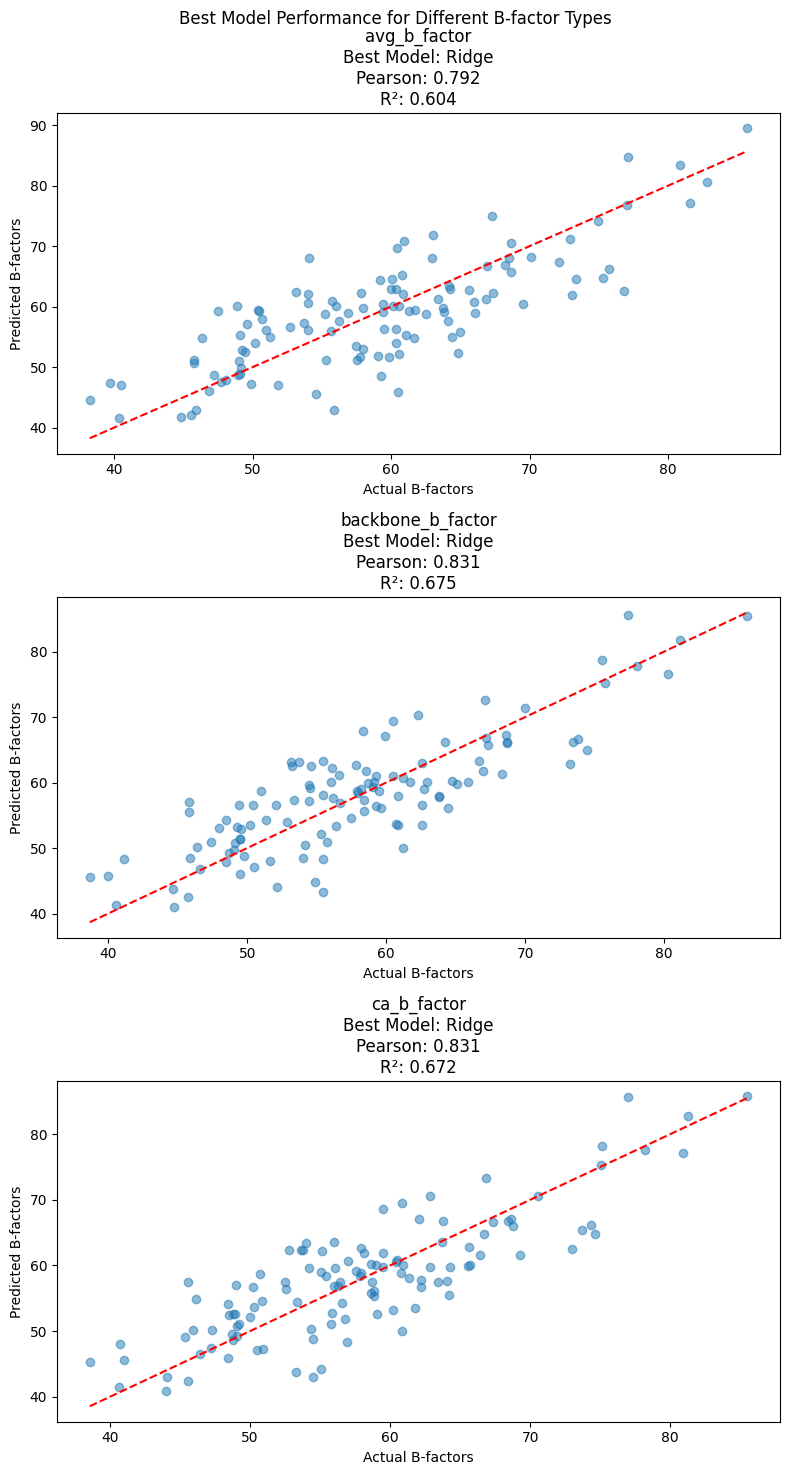


Results for avg_b_factor:
Best Model: Ridge
MSE: 37.542
R²: 0.604
Pearson: 0.792

Results for backbone_b_factor:
Best Model: Ridge
MSE: 27.789
R²: 0.675
Pearson: 0.831

Results for ca_b_factor:
Best Model: Ridge
MSE: 28.294
R²: 0.672
Pearson: 0.831


In [17]:
import numpy as np
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import joblib  # To save models
import os

def evaluate_models(X, y, model_name, model):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    pearson, _ = pearsonr(y_test, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'pearson': pearson,
        'y_test': y_test,
        'y_pred': y_pred,
        'model_name': model_name,
        'model': model  # Store the trained model
    }

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0)
}

# B-factor types
b_factor_types = ["avg_b_factor", "backbone_b_factor", "ca_b_factor"]

# Directory to save models and plots
os.makedirs("saved_models", exist_ok=True)
os.makedirs("saved_plots", exist_ok=True)

# Store results
results = {}

# For each B-factor type
for b_type in b_factor_types:
    results[b_type] = []

    # Get data for this B-factor type
    sequence = df['sequence'].iloc[0]
    b_factors = df[b_type].iloc[0]

    # For each model
    for model_name, model in models.items():
        model_results = evaluate_models(embeddings, b_factors, model_name, model)
        results[b_type].append(model_results)

    # Sort results by R² score and keep only the best model
    results[b_type].sort(key=lambda x: x['r2'], reverse=True)
    best_model_result = results[b_type][0]  # Keep only the best model
    results[b_type] = best_model_result

    # Save the best model
    model_filename = f"saved_models/{b_type}_{best_model_result['model_name']}_model.joblib"
    joblib.dump(best_model_result['model'], model_filename)
    print(f"Saved model for {b_type} with {best_model_result['model_name']} as {model_filename}")

# Plot and save results
fig, axes = plt.subplots(len(b_factor_types), 1, figsize=(8, 15))
fig.suptitle('Best Model Performance for Different B-factor Types')

for i, b_type in enumerate(b_factor_types):
    res = results[b_type]

    # Plot scatter and line for actual vs predicted B-factors
    axes[i].scatter(res['y_test'], res['y_pred'], alpha=0.5)
    axes[i].plot([min(res['y_test']), max(res['y_test'])],
                 [min(res['y_test']), max(res['y_test'])],
                 'r--')
    axes[i].set_title(f'{b_type}\nBest Model: {res["model_name"]}\nPearson: {res["pearson"]:.3f}\nR²: {res["r2"]:.3f}')
    axes[i].set_xlabel('Actual B-factors')
    axes[i].set_ylabel('Predicted B-factors')

    # Save each plot individually
    plot_filename = f"saved_plots/{b_type}_{res['model_name']}_plot.png"
    fig.savefig(plot_filename)
    print(f"Saved plot for {b_type} as {plot_filename}")

plt.tight_layout()
plt.show()

# Print detailed results
for b_type in b_factor_types:
    res = results[b_type]
    print(f"\nResults for {b_type}:")
    print(f"Best Model: {res['model_name']}")
    print(f"MSE: {res['mse']:.3f}")
    print(f"R²: {res['r2']:.3f}")
    print(f"Pearson: {res['pearson']:.3f}")


Training models for avg_b_factor

Training model with:
Hidden Size: 64, Layers: 2, Dropout: 0.1, LR: 0.001
Epoch [20/100], Loss: 0.3967
Epoch [40/100], Loss: 0.1045
Epoch [60/100], Loss: 0.0258
Epoch [80/100], Loss: 0.0130
Epoch [100/100], Loss: 0.0100
Pearson: 0.656, MSE: 60.298

Training model with:
Hidden Size: 64, Layers: 2, Dropout: 0.1, LR: 0.0001
Epoch [20/100], Loss: 0.8734
Epoch [40/100], Loss: 0.7573
Epoch [60/100], Loss: 0.6341
Epoch [80/100], Loss: 0.5164
Epoch [100/100], Loss: 0.3931
Pearson: 0.578, MSE: 63.705

Training model with:
Hidden Size: 64, Layers: 2, Dropout: 0.05, LR: 0.001
Epoch [20/100], Loss: 0.3643
Epoch [40/100], Loss: 0.0627
Epoch [60/100], Loss: 0.0127
Epoch [80/100], Loss: 0.0062
Epoch [100/100], Loss: 0.0049
Pearson: 0.679, MSE: 61.248

Training model with:
Hidden Size: 64, Layers: 2, Dropout: 0.05, LR: 0.0001
Epoch [20/100], Loss: 0.9326
Epoch [40/100], Loss: 0.8311
Epoch [60/100], Loss: 0.7287
Epoch [80/100], Loss: 0.6128
Epoch [100/100], Loss: 0.487

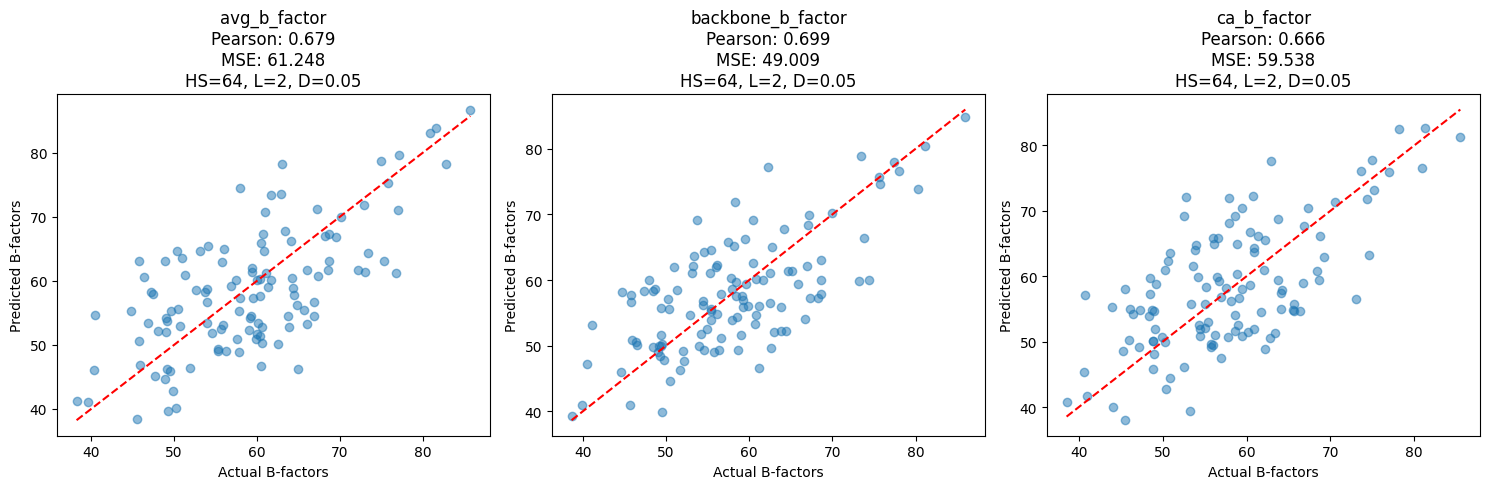


Best Models Summary:

avg_b_factor:
  Pearson: 0.679
  MSE: 61.248
  Hidden Size: 64
  Layers: 2
  Dropout: 0.05
  Learning Rate: 0.001

backbone_b_factor:
  Pearson: 0.699
  MSE: 49.009
  Hidden Size: 64
  Layers: 2
  Dropout: 0.05
  Learning Rate: 0.001

ca_b_factor:
  Pearson: 0.666
  MSE: 59.538
  Hidden Size: 64
  Layers: 2
  Dropout: 0.05
  Learning Rate: 0.001


In [18]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from itertools import product
import os

# Ensure directories for saved models and plots exist
os.makedirs("saved_rnn_models", exist_ok=True)
os.makedirs("saved_rnn_plots", exist_ok=True)

class SimpleRNN(nn.Module):
    def __init__(self, input_size=1024, hidden_size=128, num_layers=2, dropout=0.2):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        predictions = self.fc(rnn_out)
        return predictions.squeeze(-1)

class ProteinDataset(Dataset):
    def __init__(self, embeddings, b_factors):
        self.embeddings = torch.FloatTensor(embeddings)
        self.b_factors = torch.FloatTensor(b_factors)
        if len(self.embeddings.shape) == 2:
            self.embeddings = self.embeddings.unsqueeze(0)
            self.b_factors = self.b_factors.unsqueeze(0)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.b_factors[idx]

def train_rnn_model(embeddings, b_factors, hidden_size, num_layers, dropout, lr, n_epochs=100):
    embeddings = np.array(embeddings)
    b_factors = np.array(b_factors)

    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, b_factors, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).squeeze()
    y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).squeeze()

    train_dataset = ProteinDataset(X_train, y_train_scaled)
    test_dataset = ProteinDataset(X_test, y_test_scaled)

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SimpleRNN(hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0

        for batch_embeddings, batch_b_factors in train_loader:
            batch_embeddings, batch_b_factors = batch_embeddings.to(device), batch_b_factors.to(device)

            optimizer.zero_grad()
            predictions = model(batch_embeddings)
            loss = criterion(predictions, batch_b_factors)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

    model.eval()
    all_predictions, all_targets = [], []

    with torch.no_grad():
        for batch_embeddings, batch_b_factors in test_loader:
            batch_embeddings = batch_embeddings.to(device)
            predictions = model(batch_embeddings)

            predictions_np = scaler.inverse_transform(
                predictions.cpu().numpy().reshape(-1, 1)
            ).squeeze()
            targets_np = scaler.inverse_transform(
                batch_b_factors.numpy().reshape(-1, 1)
            ).squeeze()

            all_predictions.extend(predictions_np)
            all_targets.extend(targets_np)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    pearson_corr, _ = pearsonr(all_targets, all_predictions)
    mse = mean_squared_error(all_targets, all_predictions)

    return model, pearson_corr, mse, all_predictions, all_targets

# Define hyperparameter combinations
hidden_sizes = [64, 128]
num_layers_options = [2, 4]
dropout_rates = [0.1, 0.05]
learning_rates = [0.001, 0.0001]

# Get all combinations (8 total)
hyperparameter_combinations = list(product(
    hidden_sizes[:1], num_layers_options[:1], dropout_rates[:2], learning_rates[:2]
))[:8]  # Limit to 8 combinations

b_factor_types = ["avg_b_factor", "backbone_b_factor", "ca_b_factor"]
best_results = {}

for b_type in b_factor_types:
    print(f"\n{'='*50}")
    print(f"Training models for {b_type}")
    print(f"{'='*50}")

    b_factors = df[b_type].iloc[0]
    models_results = []

    for hidden_size, num_layers, dropout, lr in hyperparameter_combinations:
        print(f"\nTraining model with:")
        print(f"Hidden Size: {hidden_size}, Layers: {num_layers}, Dropout: {dropout}, LR: {lr}")

        model, pearson, mse, preds, targets = train_rnn_model(
            embeddings, b_factors, hidden_size, num_layers, dropout, lr
        )

        models_results.append({
            'model': model,
            'pearson_corr': pearson,
            'mse': mse,
            'predictions': preds,
            'targets': targets,
            'hyperparameters': {
                'hidden_size': hidden_size,
                'num_layers': num_layers,
                'dropout': dropout,
                'lr': lr
            }
        })

        print(f"Pearson: {pearson:.3f}, MSE: {mse:.3f}")

    best_model = max(models_results, key=lambda x: x['pearson_corr'])
    best_results[b_type] = best_model

    # Save the best model
    model_filename = f"saved_rnn_models/{b_type}_SimpleRNN_model.pt"
    torch.save(best_model['model'].state_dict(), model_filename)
    print(f"Saved model for {b_type} as {model_filename}")

# Plot best models
plt.figure(figsize=(15, 5))

for i, b_type in enumerate(b_factor_types, 1):
    best = best_results[b_type]

    plt.subplot(1, 3, i)
    plt.scatter(best['targets'], best['predictions'], alpha=0.5)
    plt.plot([min(best['targets']), max(best['targets'])],
             [min(best['targets']), max(best['targets'])], 'r--')

    params = best['hyperparameters']
    plt.title(f"{b_type}\nPearson: {best['pearson_corr']:.3f}\nMSE: {best['mse']:.3f}\n" +
              f"HS={params['hidden_size']}, L={params['num_layers']}, D={params['dropout']}")
    plt.xlabel('Actual B-factors')
    plt.ylabel('Predicted B-factors')

    # Save the plot for each B-factor type
    plot_filename = f"saved_rnn_plots/{b_type}_SimpleRNN_plot.png"
    plt.savefig(plot_filename)
    print(f"Saved plot for {b_type} as {plot_filename}")

plt.tight_layout()
plt.show()

# Print final summary of best models
print("\nBest Models Summary:")
for b_type in b_factor_types:
    best = best_results[b_type]
    params = best['hyperparameters']
    print(f"\n{b_type}:")
    print(f"  Pearson: {best['pearson_corr']:.3f}")
    print(f"  MSE: {best['mse']:.3f}")
    print(f"  Hidden Size: {params['hidden_size']}")
    print(f"  Layers: {params['num_layers']}")
    print(f"  Dropout: {params['dropout']}")
    print(f"  Learning Rate: {params['lr']}")


Training models for avg_b_factor

Training model with:
Hidden Size: 64, Layers: 1, Dropout: 0, LR: 0.001
Epoch [20/100], Loss: 0.5411
Epoch [40/100], Loss: 0.2212
Epoch [60/100], Loss: 0.0697
Epoch [80/100], Loss: 0.0148
Epoch [100/100], Loss: 0.0020
Pearson: 0.735, MSE: 46.825

Training model with:
Hidden Size: 64, Layers: 2, Dropout: 0.1, LR: 0.001
Epoch [20/100], Loss: 0.7225
Epoch [40/100], Loss: 0.2745
Epoch [60/100], Loss: 0.1233
Epoch [80/100], Loss: 0.0557
Epoch [100/100], Loss: 0.0244
Pearson: 0.726, MSE: 49.576

Training model with:
Hidden Size: 64, Layers: 2, Dropout: 0.2, LR: 0.0001
Epoch [20/100], Loss: 0.9898
Epoch [40/100], Loss: 0.9771
Epoch [60/100], Loss: 0.9528
Epoch [80/100], Loss: 0.9180
Epoch [100/100], Loss: 0.8596
Pearson: 0.412, MSE: 83.160

Training model with:
Hidden Size: 128, Layers: 1, Dropout: 0.1, LR: 0.001


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Epoch [20/100], Loss: 0.4185
Epoch [40/100], Loss: 0.1501
Epoch [60/100], Loss: 0.0405
Epoch [80/100], Loss: 0.0064
Epoch [100/100], Loss: 0.0006
Pearson: 0.736, MSE: 46.586

Training model with:
Hidden Size: 128, Layers: 2, Dropout: 0.2, LR: 0.0001
Epoch [20/100], Loss: 0.9825
Epoch [40/100], Loss: 0.9500
Epoch [60/100], Loss: 0.8816
Epoch [80/100], Loss: 0.7551
Epoch [100/100], Loss: 0.6129
Pearson: 0.607, MSE: 60.588

Training model with:
Hidden Size: 128, Layers: 3, Dropout: 0.3, LR: 0.0001
Epoch [20/100], Loss: 0.9988
Epoch [40/100], Loss: 0.9942
Epoch [60/100], Loss: 0.9788
Epoch [80/100], Loss: 0.9291
Epoch [100/100], Loss: 0.8568
Pearson: 0.238, MSE: 89.777
Saved model for avg_b_factor as saved_lstm_models/avg_b_factor_LSTM_model.pt

Training models for backbone_b_factor

Training model with:
Hidden Size: 64, Layers: 1, Dropout: 0, LR: 0.001
Epoch [20/100], Loss: 0.5920
Epoch [40/100], Loss: 0.2499
Epoch [60/100], Loss: 0.0890
Epoch [80/100], Loss: 0.0233
Epoch [100/100], Loss:

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Epoch [20/100], Loss: 0.4644
Epoch [40/100], Loss: 0.1514
Epoch [60/100], Loss: 0.0447
Epoch [80/100], Loss: 0.0088
Epoch [100/100], Loss: 0.0012
Pearson: 0.773, MSE: 36.870

Training model with:
Hidden Size: 128, Layers: 2, Dropout: 0.2, LR: 0.0001
Epoch [20/100], Loss: 0.9875
Epoch [40/100], Loss: 0.9649
Epoch [60/100], Loss: 0.9134
Epoch [80/100], Loss: 0.8062
Epoch [100/100], Loss: 0.6669
Pearson: 0.580, MSE: 58.710

Training model with:
Hidden Size: 128, Layers: 3, Dropout: 0.3, LR: 0.0001
Epoch [20/100], Loss: 0.9977
Epoch [40/100], Loss: 0.9911
Epoch [60/100], Loss: 0.9658
Epoch [80/100], Loss: 0.9046
Epoch [100/100], Loss: 0.8417
Pearson: 0.231, MSE: 82.234
Saved model for backbone_b_factor as saved_lstm_models/backbone_b_factor_LSTM_model.pt

Training models for ca_b_factor

Training model with:
Hidden Size: 64, Layers: 1, Dropout: 0, LR: 0.001
Epoch [20/100], Loss: 0.5606
Epoch [40/100], Loss: 0.2274
Epoch [60/100], Loss: 0.0707
Epoch [80/100], Loss: 0.0150
Epoch [100/100], L

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Epoch [20/100], Loss: 0.4434
Epoch [40/100], Loss: 0.1499
Epoch [60/100], Loss: 0.0394
Epoch [80/100], Loss: 0.0057
Epoch [100/100], Loss: 0.0007
Pearson: 0.753, MSE: 39.660

Training model with:
Hidden Size: 128, Layers: 2, Dropout: 0.2, LR: 0.0001
Epoch [20/100], Loss: 0.9885
Epoch [40/100], Loss: 0.9652
Epoch [60/100], Loss: 0.9193
Epoch [80/100], Loss: 0.8273
Epoch [100/100], Loss: 0.6866
Pearson: 0.581, MSE: 58.657

Training model with:
Hidden Size: 128, Layers: 3, Dropout: 0.3, LR: 0.0001
Epoch [20/100], Loss: 0.9981
Epoch [40/100], Loss: 0.9907
Epoch [60/100], Loss: 0.9670
Epoch [80/100], Loss: 0.9129
Epoch [100/100], Loss: 0.8452
Pearson: 0.303, MSE: 79.005
Saved model for ca_b_factor as saved_lstm_models/ca_b_factor_LSTM_model.pt
Saved plot for avg_b_factor as saved_lstm_plots/avg_b_factor_LSTM_plot.png
Saved plot for backbone_b_factor as saved_lstm_plots/backbone_b_factor_LSTM_plot.png
Saved plot for ca_b_factor as saved_lstm_plots/ca_b_factor_LSTM_plot.png


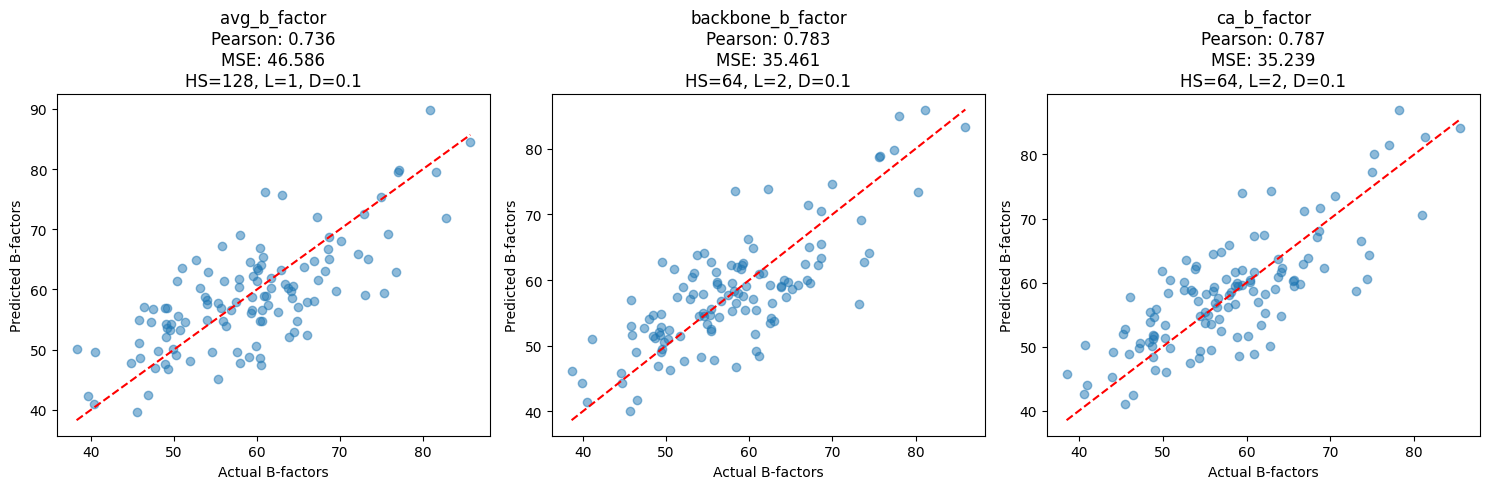


Best Models Summary:

avg_b_factor:
  Pearson: 0.736
  MSE: 46.586
  Hidden Size: 128
  Layers: 1
  Dropout: 0.1
  Learning Rate: 0.001

backbone_b_factor:
  Pearson: 0.783
  MSE: 35.461
  Hidden Size: 64
  Layers: 2
  Dropout: 0.1
  Learning Rate: 0.001

ca_b_factor:
  Pearson: 0.787
  MSE: 35.239
  Hidden Size: 64
  Layers: 2
  Dropout: 0.1
  Learning Rate: 0.001


In [19]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import os

# Ensure directories for saved models and plots exist
os.makedirs("saved_lstm_models", exist_ok=True)
os.makedirs("saved_lstm_plots", exist_ok=True)

class LSTMModel(nn.Module):
    def __init__(self, input_size=1024, hidden_size=128, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.fc(lstm_out)
        return predictions.squeeze(-1)

class ProteinDataset(Dataset):
    def __init__(self, embeddings, b_factors):
        self.embeddings = torch.FloatTensor(embeddings)
        self.b_factors = torch.FloatTensor(b_factors)
        if len(self.embeddings.shape) == 2:
            self.embeddings = self.embeddings.unsqueeze(0)
            self.b_factors = self.b_factors.unsqueeze(0)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.b_factors[idx]

def train_lstm_model(embeddings, b_factors, hidden_size, num_layers, dropout, lr, n_epochs=100):
    embeddings = np.array(embeddings)
    b_factors = np.array(b_factors)
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, b_factors, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).squeeze()
    y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).squeeze()

    train_dataset = ProteinDataset(X_train, y_train_scaled)
    test_dataset = ProteinDataset(X_test, y_test_scaled)

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LSTMModel(hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        for batch_embeddings, batch_b_factors in train_loader:
            batch_embeddings, batch_b_factors = batch_embeddings.to(device), batch_b_factors.to(device)
            optimizer.zero_grad()
            predictions = model(batch_embeddings)
            loss = criterion(predictions, batch_b_factors)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

    # Evaluation
    model.eval()
    all_predictions, all_targets = [], []
    with torch.no_grad():
        for batch_embeddings, batch_b_factors in test_loader:
            batch_embeddings = batch_embeddings.to(device)
            predictions = model(batch_embeddings)
            predictions_np = scaler.inverse_transform(predictions.cpu().numpy().reshape(-1, 1)).squeeze()
            targets_np = scaler.inverse_transform(batch_b_factors.numpy().reshape(-1, 1)).squeeze()
            all_predictions.extend(predictions_np)
            all_targets.extend(targets_np)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    pearson_corr, _ = pearsonr(all_targets, all_predictions)
    mse = mean_squared_error(all_targets, all_predictions)

    return model, pearson_corr, mse, all_predictions, all_targets

# Define model configurations
model_configs = [
    {'hidden_size': 64, 'num_layers': 1, 'dropout': 0, 'lr': 0.001},
    {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.001},
    {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.0001},
    {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.001},
    {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.0001},
    {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.3, 'lr': 0.0001}
]

b_factor_types = ["avg_b_factor", "backbone_b_factor", "ca_b_factor"]
best_results = {}

for b_type in b_factor_types:
    print(f"\n{'='*50}")
    print(f"Training models for {b_type}")
    print(f"{'='*50}")

    b_factors = df[b_type].iloc[0]
    models_results = []

    for config in model_configs:
        print(f"\nTraining model with:")
        print(f"Hidden Size: {config['hidden_size']}, Layers: {config['num_layers']}, "
              f"Dropout: {config['dropout']}, LR: {config['lr']}")

        model, pearson, mse, preds, targets = train_lstm_model(
            embeddings,
            b_factors,
            config['hidden_size'],
            config['num_layers'],
            config['dropout'],
            config['lr']
        )

        models_results.append({
            'model': model,
            'pearson_corr': pearson,
            'mse': mse,
            'predictions': preds,
            'targets': targets,
            'config': config
        })

        print(f"Pearson: {pearson:.3f}, MSE: {mse:.3f}")

    # Find and save best model
    best_model = max(models_results, key=lambda x: x['pearson_corr'])
    best_results[b_type] = best_model

    # Save the best model
    model_filename = f"saved_lstm_models/{b_type}_LSTM_model.pt"
    torch.save(best_model['model'].state_dict(), model_filename)
    print(f"Saved model for {b_type} as {model_filename}")

# Plot best models
plt.figure(figsize=(15, 5))

for i, b_type in enumerate(b_factor_types, 1):
    best = best_results[b_type]
    plt.subplot(1, 3, i)
    plt.scatter(best['targets'], best['predictions'], alpha=0.5)
    plt.plot([min(best['targets']), max(best['targets'])],
             [min(best['targets']), max(best['targets'])], 'r--')
    config = best['config']
    plt.title(f"{b_type}\nPearson: {best['pearson_corr']:.3f}\nMSE: {best['mse']:.3f}\n" +
              f"HS={config['hidden_size']}, L={config['num_layers']}, D={config['dropout']}")
    plt.xlabel('Actual B-factors')
    plt.ylabel('Predicted B-factors')

    # Save the plot for each B-factor type
    plot_filename = f"saved_lstm_plots/{b_type}_LSTM_plot.png"
    plt.savefig(plot_filename)
    print(f"Saved plot for {b_type} as {plot_filename}")

plt.tight_layout()
plt.show()

# Print final summary of best models
print("\nBest Models Summary:")
for b_type in b_factor_types:
    best = best_results[b_type]
    config = best['config']
    print(f"\n{b_type}:")
    print(f"  Pearson: {best['pearson_corr']:.3f}")
    print(f"  MSE: {best['mse']:.3f}")
    print(f"  Hidden Size: {config['hidden_size']}")
    print(f"  Layers: {config['num_layers']}")
    print(f"  Dropout: {config['dropout']}")
    print(f"  Learning Rate: {config['lr']}")


In [25]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Define the directory where models and visualizations will be saved
save_dir = "output"
os.makedirs(save_dir, exist_ok=True)  # Creates the directory if it doesn't exist

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))

        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def forward(self, x, mask=None):
        batch_size = x.size(0)

        # Linear projections and reshape
        Q = self.W_q(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Apply attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Reshape and apply final linear projection
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.W_o(attn_output)

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Self-attention block
        attention_output = self.attention(x)
        x = self.norm1(x + self.dropout(attention_output))

        # Feed-forward block
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x

class TransformerModel(nn.Module):
    def __init__(self, input_size=1024, d_model=256, num_heads=8, d_ff=1024,
                 num_layers=3, dropout=0.1):
        super().__init__()

        self.input_projection = nn.Linear(input_size, d_model)

        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.final_norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.input_projection(x)

        for block in self.transformer_blocks:
            x = block(x)

        x = self.final_norm(x)
        x = self.output_layer(x)
        return x.squeeze(-1)

class ProteinDataset(Dataset):
    def __init__(self, embeddings, b_factors):
        self.embeddings = torch.FloatTensor(embeddings)
        self.b_factors = torch.FloatTensor(b_factors)

        if len(self.embeddings.shape) == 2:
            self.embeddings = self.embeddings.unsqueeze(0)
            self.b_factors = self.b_factors.unsqueeze(0)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.b_factors[idx]


Training models for avg_b_factor

Training model with:
d_model: 128, heads: 4, 
d_ff: 512, layers: 2, 
dropout: 0.1, lr: 0.001
Epoch [10/100], Train Loss: 0.3690, Val Loss: 0.4507
Epoch [20/100], Train Loss: 0.1211, Val Loss: 0.3287
Epoch [30/100], Train Loss: 0.0394, Val Loss: 0.2895
Early stopping at epoch 38
Pearson: 0.777, MSE: 42.320

Training model with:
d_model: 128, heads: 8, 
d_ff: 512, layers: 3, 
dropout: 0.1, lr: 0.0001
Epoch [10/100], Train Loss: 0.7429, Val Loss: 0.4494
Epoch [20/100], Train Loss: 0.5146, Val Loss: 0.3936
Epoch [30/100], Train Loss: 0.3422, Val Loss: 0.3385
Epoch [40/100], Train Loss: 0.2104, Val Loss: 0.2977
Epoch [50/100], Train Loss: 0.1371, Val Loss: 0.2808
Epoch [60/100], Train Loss: 0.0799, Val Loss: 0.2797
Early stopping at epoch 67
Pearson: 0.785, MSE: 40.138

Training model with:
d_model: 256, heads: 4, 
d_ff: 1024, layers: 3, 
dropout: 0.2, lr: 0.001
Epoch [10/100], Train Loss: 0.5942, Val Loss: 0.3883
Epoch [20/100], Train Loss: 0.2487, Val Lo

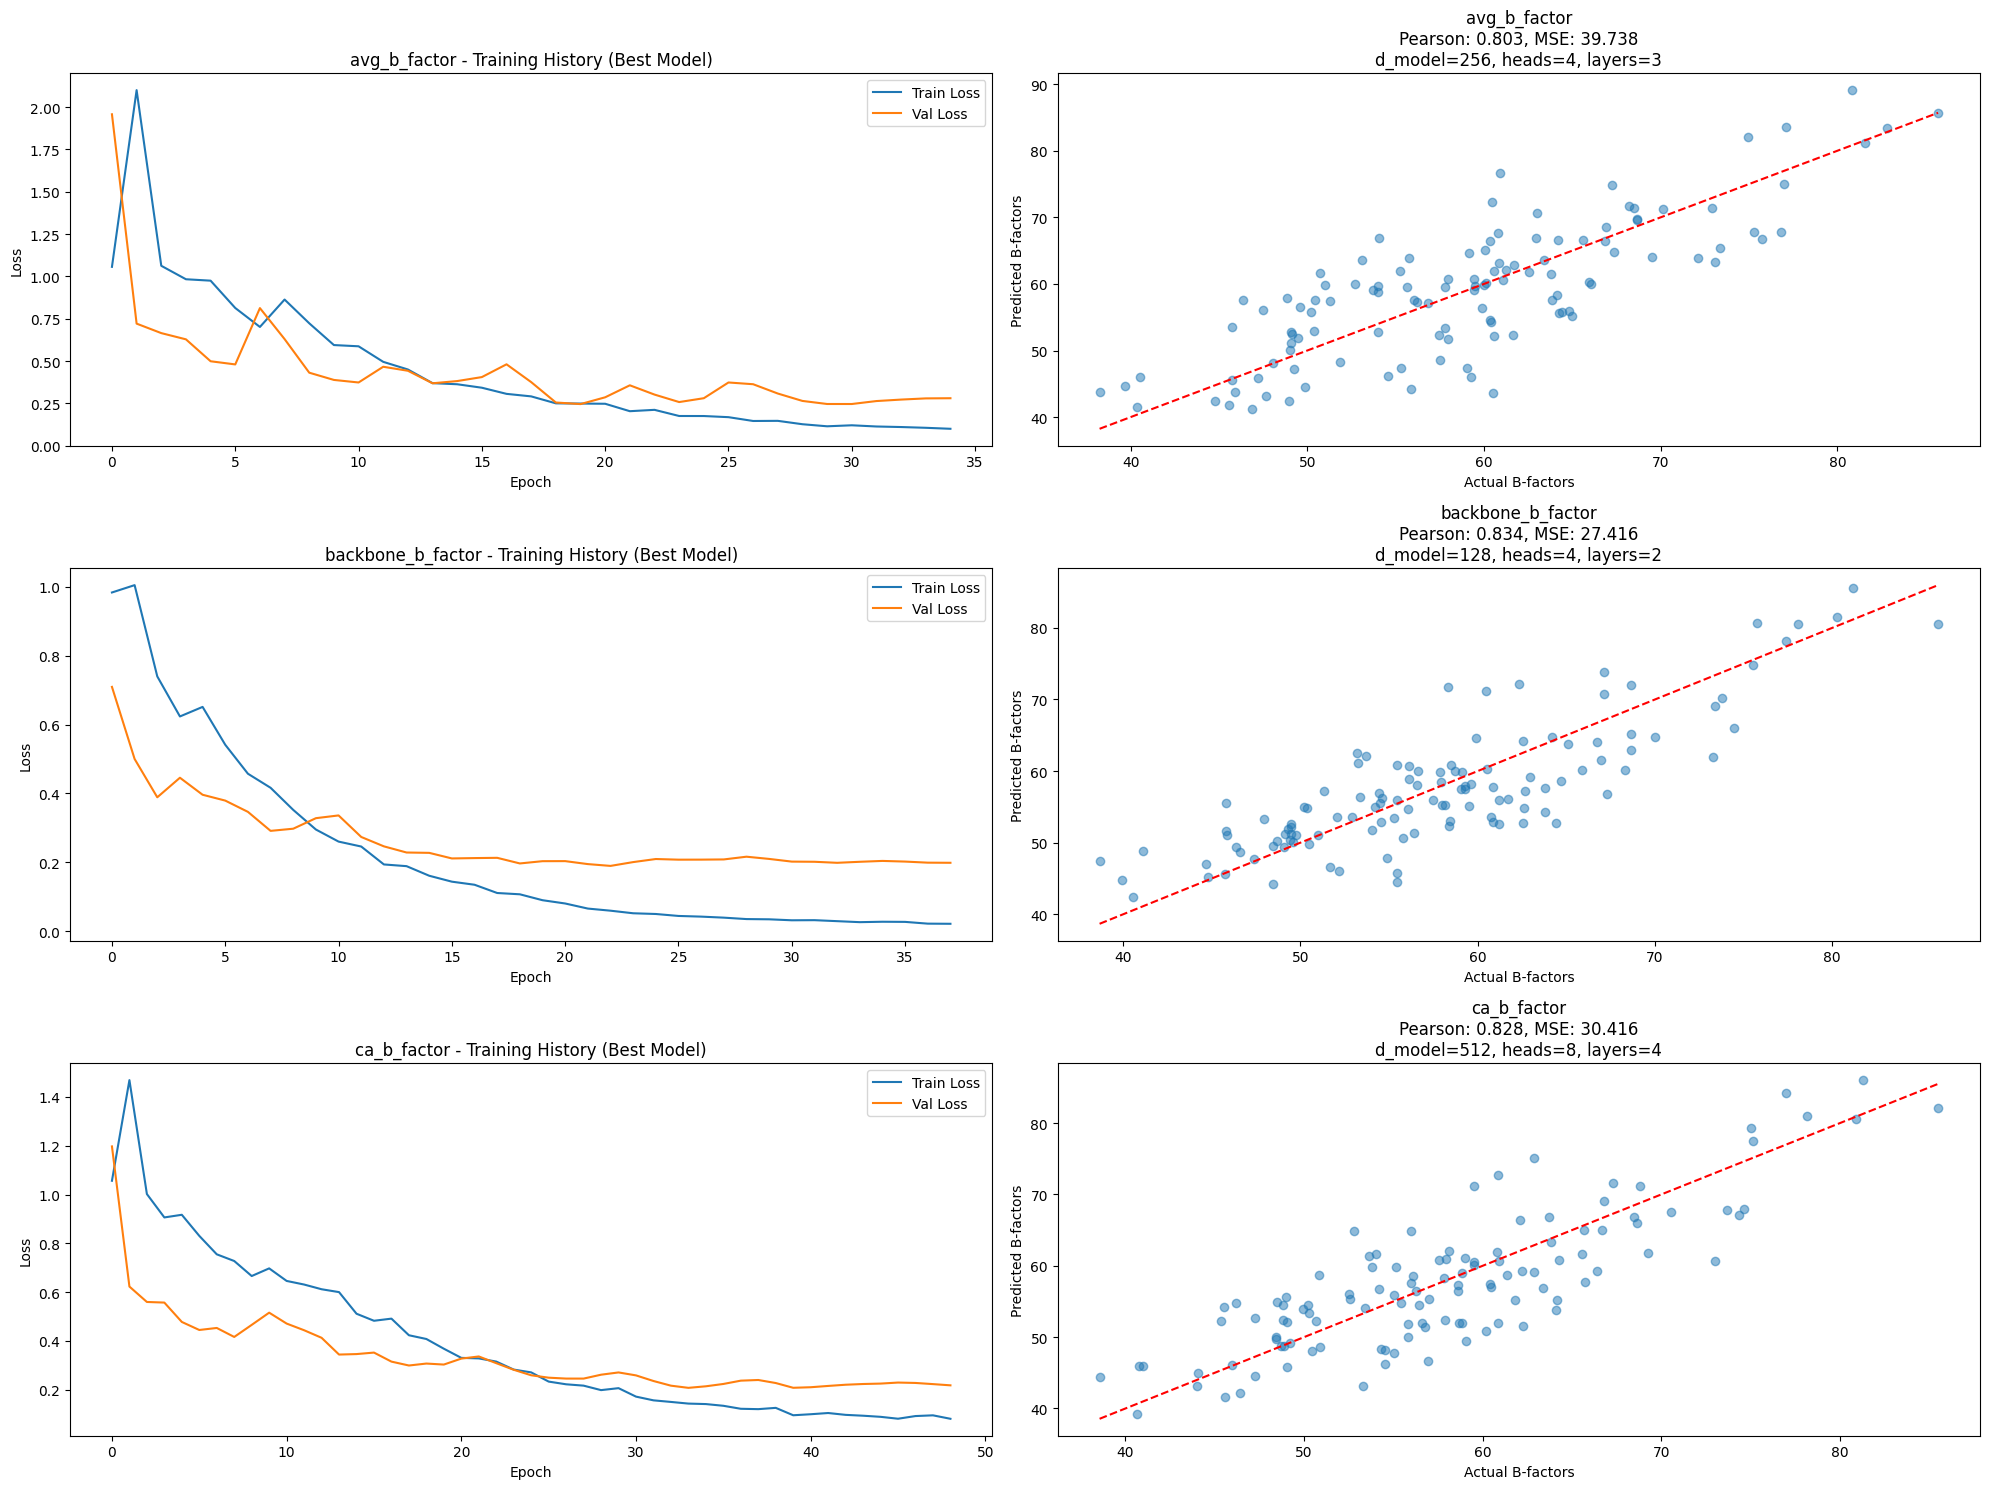

Visualizations saved to output/best_models_visualizations.png

Best Models Summary:

avg_b_factor:
  Pearson: 0.803
  MSE: 39.738
  d_model: 256
  num_heads: 4
  d_ff: 1024
  num_layers: 3
  dropout: 0.2
  learning rate: 0.001

backbone_b_factor:
  Pearson: 0.834
  MSE: 27.416
  d_model: 128
  num_heads: 4
  d_ff: 512
  num_layers: 2
  dropout: 0.1
  learning rate: 0.001

ca_b_factor:
  Pearson: 0.828
  MSE: 30.416
  d_model: 512
  num_heads: 8
  d_ff: 2048
  num_layers: 4
  dropout: 0.3
  learning rate: 0.0001


In [26]:
import os

def train_transformer_model(embeddings, b_factors, d_model, num_heads, d_ff, num_layers, dropout, lr, n_epochs=100):
    # Convert to numpy arrays
    embeddings = np.array(embeddings)
    b_factors = np.array(b_factors)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, b_factors, test_size=0.2, random_state=42
    )

    # Scale B-factors
    scaler = StandardScaler()
    y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).squeeze()
    y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).squeeze()

    # Create datasets and dataloaders
    train_dataset = ProteinDataset(X_train, y_train_scaled)
    test_dataset = ProteinDataset(X_test, y_test_scaled)

    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize model with specific hyperparameters
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TransformerModel(
        d_model=d_model,
        num_heads=num_heads,
        d_ff=d_ff,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # Training loop with early stopping
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 15
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0

        for batch_embeddings, batch_b_factors in train_loader:
            batch_embeddings = batch_embeddings.to(device)
            batch_b_factors = batch_b_factors.to(device)

            optimizer.zero_grad()
            predictions = model(batch_embeddings)
            loss = criterion(predictions, batch_b_factors)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_embeddings, batch_b_factors in test_loader:
                batch_embeddings = batch_embeddings.to(device)
                batch_b_factors = batch_b_factors.to(device)
                predictions = model(batch_embeddings)
                val_loss += criterion(predictions, batch_b_factors).item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # Final evaluation
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_embeddings, batch_b_factors in test_loader:
            batch_embeddings = batch_embeddings.to(device)
            predictions = model(batch_embeddings)

            predictions_np = scaler.inverse_transform(
                predictions.cpu().numpy().reshape(-1, 1)
            ).squeeze()
            targets_np = scaler.inverse_transform(
                batch_b_factors.numpy().reshape(-1, 1)
            ).squeeze()

            all_predictions.extend(predictions_np)
            all_targets.extend(targets_np)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    pearson_corr, _ = pearsonr(all_targets, all_predictions)
    mse = mean_squared_error(all_targets, all_predictions)

    return model, pearson_corr, mse, all_predictions, all_targets, train_losses, val_losses

# Define model configurations
model_configs = [
    {'d_model': 128, 'num_heads': 4, 'd_ff': 512, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.001},
    {'d_model': 128, 'num_heads': 8, 'd_ff': 512, 'num_layers': 3, 'dropout': 0.1, 'lr': 0.0001},
    {'d_model': 256, 'num_heads': 4, 'd_ff': 1024, 'num_layers': 3, 'dropout': 0.2, 'lr': 0.001},
    {'d_model': 256, 'num_heads': 8, 'd_ff': 1024, 'num_layers': 4, 'dropout': 0.2, 'lr': 0.0001},
    {'d_model': 128, 'num_heads': 4, 'd_ff': 512, 'num_layers': 3, 'dropout': 0.3, 'lr': 0.0005},
    {'d_model': 256, 'num_heads': 4, 'd_ff': 1024, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.0005},
    {'d_model': 512, 'num_heads': 8, 'd_ff': 2048, 'num_layers': 4, 'dropout': 0.3, 'lr': 0.0001},
    {'d_model': 512, 'num_heads': 16, 'd_ff': 2048, 'num_layers': 3, 'dropout': 0.2, 'lr': 0.00005}
]

b_factor_types = ["avg_b_factor", "backbone_b_factor", "ca_b_factor"]
best_results = {}

for b_type in b_factor_types:
    print(f"\n{'='*50}")
    print(f"Training models for {b_type}")
    print(f"{'='*50}")

    b_factors = df[b_type].iloc[0]
    models_results = []

    for config in model_configs:
        print(f"\nTraining model with:")
        print(f"d_model: {config['d_model']}, heads: {config['num_heads']}, ")
        print(f"d_ff: {config['d_ff']}, layers: {config['num_layers']}, ")
        print(f"dropout: {config['dropout']}, lr: {config['lr']}")

        model, pearson, mse, preds, targets, train_losses, val_losses = train_transformer_model(
            embeddings,
            b_factors,
            **config
        )

        models_results.append({
            'model': model,
            'pearson_corr': pearson,
            'mse': mse,
            'predictions': preds,
            'targets': targets,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'config': config
        })

        print(f"Pearson: {pearson:.3f}, MSE: {mse:.3f}")

    # Find best model
    best_model = max(models_results, key=lambda x: x['pearson_corr'])
    best_results[b_type] = best_model

    # Save the best model for this B-factor type
    model_save_path = os.path.join(save_dir, f"best_model_{b_type}.pth")
    torch.save(best_model['model'].state_dict(), model_save_path)
    print(f"Best model for {b_type} saved to {model_save_path}")

# Plot best models and save plots
plt.figure(figsize=(20, 15))

for i, b_type in enumerate(b_factor_types, 1):
    best = best_results[b_type]

    # Plot training history
    plt.subplot(3, 2, 2*i-1)
    plt.plot(best['train_losses'], label='Train Loss')
    plt.plot(best['val_losses'], label='Val Loss')
    plt.title(f'{b_type} - Training History (Best Model)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot predictions
    plt.subplot(3, 2, 2*i)
    plt.scatter(best['targets'], best['predictions'], alpha=0.5)
    plt.plot([min(best['targets']), max(best['targets'])],
             [min(best['targets']), max(best['targets'])], 'r--')

    config = best['config']
    plt.title(f"{b_type}\nPearson: {best['pearson_corr']:.3f}, MSE: {best['mse']:.3f}\n" +
              f"d_model={config['d_model']}, heads={config['num_heads']}, layers={config['num_layers']}")
    plt.xlabel('Actual B-factors')
    plt.ylabel('Predicted B-factors')

# Save the combined plot of training histories and predictions
plot_save_path = os.path.join(save_dir, "best_models_visualizations.png")
plt.tight_layout()
plt.savefig(plot_save_path)
plt.show()
print(f"Visualizations saved to {plot_save_path}")

# Print summary of best models
print("\nBest Models Summary:")
for b_type in b_factor_types:
    best = best_results[b_type]
    config = best['config']
    print(f"\n{b_type}:")
    print(f"  Pearson: {best['pearson_corr']:.3f}")
    print(f"  MSE: {best['mse']:.3f}")
    print(f"  d_model: {config['d_model']}")
    print(f"  num_heads: {config['num_heads']}")
    print(f"  d_ff: {config['d_ff']}")
    print(f"  num_layers: {config['num_layers']}")
    print(f"  dropout: {config['dropout']}")
    print(f"  learning rate: {config['lr']}")

In [27]:
import shutil

# Create a zip file of the `output` directory
shutil.make_archive('output_files', 'zip', 'output')

'/content/output_files.zip'